# <span style="color:Orange"> Project 1 </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from progressbar import ProgressBar
plt.style.use('seaborn-whitegrid')
from scipy.ndimage.filters import gaussian_filter1d

## <span style="color:red"> Problem</span>

Develop a program using Monte Carlo method to simulate the Ising model on a square  
lattice (2-dimension: L×L) at the no external magnetic field case (H=0). Choose the  
lattice edge L=20. Use the periodic boundary condition. And only consider the nearest  
coupling/interaction.

**Required parts of the project:**
1. Introduction
   - Briefly describe the phases (ferromagnetic and paramagnetic) and the phase  
   transition; Microstates and its probability; Statistical average;
   - Ising model: spin and its possible values; the energy of the system; how many
   microstates for N spins (N= L×L).
   - Monte Carlo method on a Ising model; Important sampling; How to calculate Eflip.  
   
2. Pseudocode of ‘float chart’ of your design of the Monte Carlo simulation.  

3. Write your own code (in Matlab or python). Attach your code.

4. Calculate the magnetization M (= \<s\>) and the total energy \<E\> for 50 different   
    temperature steps from T=0.0 to T=5.0 (or a range your can observe a phase  
    transition). Plot them against T’s. Discuss the physics from your results.   
    Use the unit J/kB=1 (so your T is in J/kB and \<E\> is in J).   
    Estimate the Curry temperature Tc. 



## <span style="color:green"> Solution </span>

## <span style="color:orange"> Get random Lattice </span>

In [2]:
################################################################################
######################## get_rand_lattice ######################################
def get_spin_lattice( size_lattice = (20, 20),
                      prob_spin_up = 0.5,
                      plot_enabled = True ):
    
    """
    General info:
        This function returns a random 2D-numpy-array of spins of given size
        <size_lattice>.
    Arguments:
        size_lattice : 2D lattice size
        prob_spin_up : Probability of spin = +1 in the lattice points
    """
    
    pts_rand_2D                    = np.random.random(size_lattice)
    spins                          = np.zeros(size_lattice)
    spins[pts_rand_2D <  prob_spin_up] = +1
    spins[pts_rand_2D >= prob_spin_up] = -1
    if plot_enabled: plt.imshow(spins)
    
    return spins
######################## get_rand_lattice ######################################
################################################################################

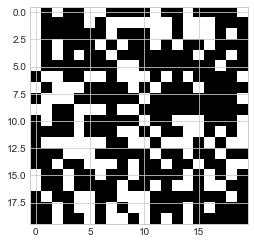

In [3]:
spins_old = get_spin_lattice( size_lattice = [20, 20],
                              prob_spin_up = 0.6 )

## <span style="color:orange"> Get total Energy </span>

In [4]:
################################################################################
######################## get_E_total ###########################################
def get_E_total(spins):
    
    """
    General info:
        This function calculates energy of the lattice spins for ising model.
    Arguments:
        spins : input of which we have to calculate energy
    """
    
    spins  = np.array(spins)
    n_rows = np.shape(spins)[0]
    n_cols = np.shape(spins)[1]

    # Loop over lattice points to calculate energy >>
    E = 0
    for i in range(n_rows):
        for j in range(n_cols):
            i_u = i - 1 if not(i == 0)          else n_rows - 1     # << index of row up
            i_d = i + 1 if not(i == n_rows - 1) else 0              # << index of row down
            j_l = j - 1 if not(j == 0)          else n_cols - 1     # << index of col left
            j_r = j + 1 if not(j == n_cols - 1) else 0              # << index of col right
            E   = E - spins[i, j] * (spins[i_u, j] + spins[i_d, j] + spins[i, j_l] + spins[i, j_r])
    E   = E / 2
    return E
######################## get_E_total ###########################################
################################################################################

In [5]:
E_old = get_E_total(spins_old)
E_old

-16.0

## <span style="color:orange"> Get flip energy </span>

In [6]:
################################################################################
######################## get_E_flip ############################################
def get_E_flip( spins    = [[1, -1, 1], [-1, 1, -1], [1, -1, 1]],
                loc_spin = [1, 1] ):
    
    """
    General info:
        This function calculates change in energy (E_flip) of a lattice system 
        due to flip of one of the lattice point spin.
    Arguments:
        spins    : 2D array/list of spins
        loc_spin : location of the spin to be flipped
    """
    
    spins  = np.array(spins)
    n_rows = np.shape(spins)[0]
    n_cols = np.shape(spins)[1]
    
    i = loc_spin[0]
    j = loc_spin[1]
    
    # Neighbour points >>
    i_u = i - 1 if not(i == 0)          else n_rows - 1     # << index of row up
    i_d = i + 1 if not(i == n_rows - 1) else 0              # << index of row down
    j_l = j - 1 if not(j == 0)          else n_cols - 1     # << index of col left
    j_r = j + 1 if not(j == n_cols - 1) else 0              # << index of col right
    
    # Calculating E_flip >>
    J = 1
    E_flip = 2 * J * spins[i, j] * (spins[i_u, j] + spins[i_d, j] + spins[i, j_l] + spins[i, j_r])
    
    return E_flip
######################## get_E_flip ############################################
################################################################################

In [7]:
get_E_flip( spins    = spins_old,
            loc_spin = [18, 18] )

4.0

In [8]:
################################################################################
######################## Important "String" constants ##########################
str_spin_average = "Average spin, M"
str_temp         = "T = {T}"
######################## Important "String" constants ##########################
################################################################################

## <span style="color:orange"> Single Sweep </span>

In [9]:
################################################################################
######################## sweep_single ##########################################
def sweep_single( spins = [[-1,  1, -1],
                           [-1, -1, -1],
                           [ 1, -1,  1]],
                  T     = 1,
                  plot_enabled = True ):
    
    """
    General info:
        This function performs a single sweep across all the latice points with 
        the periodic boundary to bring the system in equilibrium with heat bath.
    Arguments:
        spins : 2D array/list of spins
        T     : Temperature of the system
    """
    
    spins = np.array(spins)
    
    n_rows = np.shape(spins)[0]
    n_cols = np.shape(spins)[1]
    
    if plot_enabled: spins_collection = [np.nan] * n_rows * n_cols
    
    # Loop for flipping spins over all lattice points >>
    spins_new = spins.copy()
    m = 0
    for i in range(n_rows):
        for j in range(n_cols):
            E_flip = get_E_flip( spins    = spins_new,
                                 loc_spin = [i, j] )
            if E_flip <= 0 or np.exp(-E_flip/T) > np.random.uniform():
                spins_new[i, j] = - spins_new[i, j]
                
            if plot_enabled: spins_collection[m] = spins_new.copy()
            m = m + 1
    
    # Plotting "i vs M" >>
    if plot_enabled:
        fig  = plt.figure(figsize = (15, 5))
        axes = plt.gca()
        axes.plot( range(n_rows*n_cols), np.average( np.average(spins_collection, 1), 1 ) )
        # Setting plot elements >>
        axes.set_title(f"{str_spin_average} vs i: T = {T}")
        axes.set_xlabel("i")
        axes.set_ylabel(str_spin_average)
        plt.show()
    
    E_total_new = 0
    
    return spins_new, E_total_new
######################## sweep_single ##########################################
################################################################################

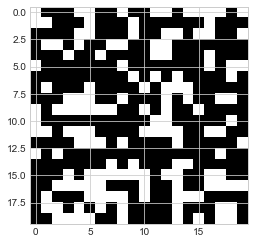

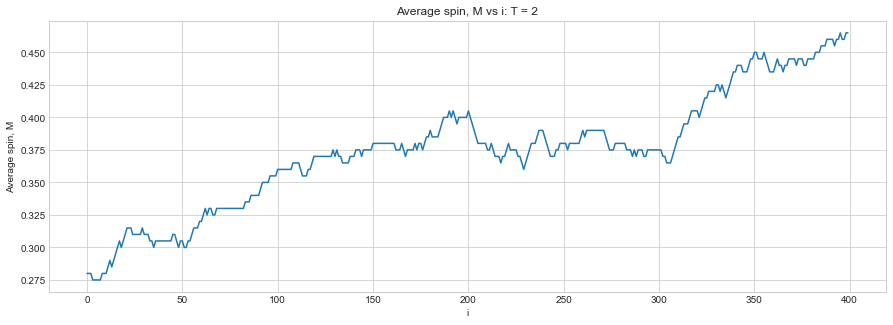

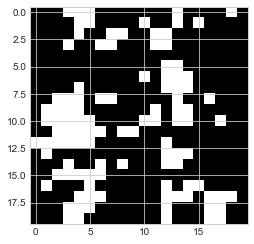

In [10]:
spins_old   = get_spin_lattice( size_lattice = [20, 20],
                                prob_spin_up = 0.6 )
E_total_old = get_E_total(spins_old)

spins_new, E_total_new = sweep_single( spins = spins_old,
                                       T     = 2 )

plt.imshow(spins_new)

## <span style="color:orange"> N sweeps </span>

In [11]:
################################################################################
######################## sweep_N ###############################################
def sweep_N( spins = [[1, -1, 1], [-1, 1, -1], [1, -1, 1]],
             n     = 1000,
             T     = 1,
             pbar_enabled = True,
             plot_enabled = True ):
    
    """
    General info:
        This function performs 'n' no. of sweeps across all the latice points with 
        the periodic boundary to bring the system in equilibrium with heat bath.
    Arguments:
        spins : 2D array/list of spins
        n     : No. of sweeps
        T     : Temperature of the system
    """
    
    from progressbar import ProgressBar
    
    spins     = np.array(spins)
    spins_new = [np.nan] * n
    
    # Loop for 'n' no. of sweeps >>
    spins_new[0] = spins.copy()
    pbar         = ProgressBar() if pbar_enabled else lambda x: x
    for i in pbar(range(1, n)):
        spins_new[i], E_new = sweep_single( spins = spins_new[i-1].copy(),
                                            T     = T,
                                            plot_enabled = False
                                          )
    spins_new = np.array(spins_new)
    
    # Plotting "i vs M" >>
    if plot_enabled:
        fig  = plt.figure(figsize = (15, 5))
        axes = plt.gca()
        axes.plot( range(n), np.average( abs(np.average(spins_new, 1)), 1 ) )
        # Setting plot elements >>
        axes.set_title(f"{str_spin_average} vs No. of sweeps: T = {T}")
        axes.set_xlabel("No. of sweeps")
        axes.set_ylabel(str_spin_average)
        axes.set_ylim([0, 1.1])
        plt.show()
    
    return spins_new, E_new
######################## sweep_N ###############################################
################################################################################

# <span style="color:orange"> 5000 sweeps to reach at equilibrium </span>

### T = 0.1

100% |########################################################################|


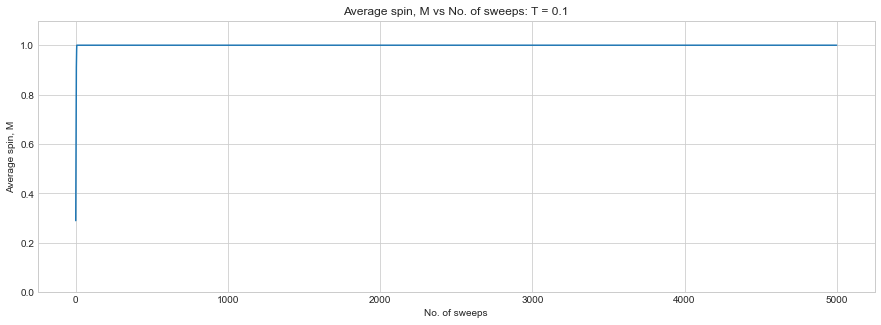

In [46]:
spins_new, E_total_new = sweep_N( spins = spins_old,
                                  n     = 5000,
                                  T     = 0.1 )

### T = 1

100% |########################################################################|


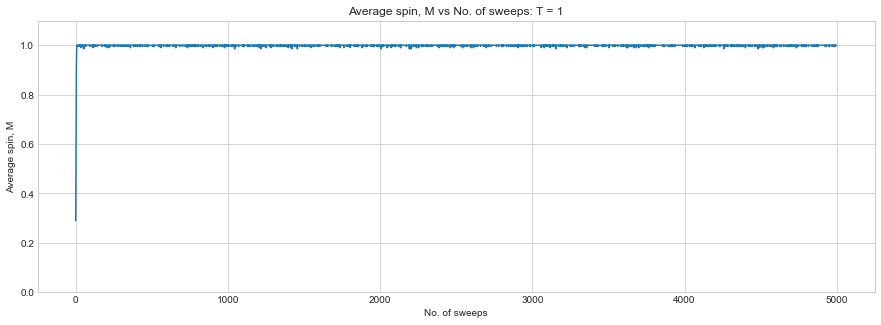

In [29]:
spins_new, E_total_new = sweep_N( spins = spins_old,
                                  n     = 5000,
                                  T     = 1 )

### T = 2

100% |########################################################################|


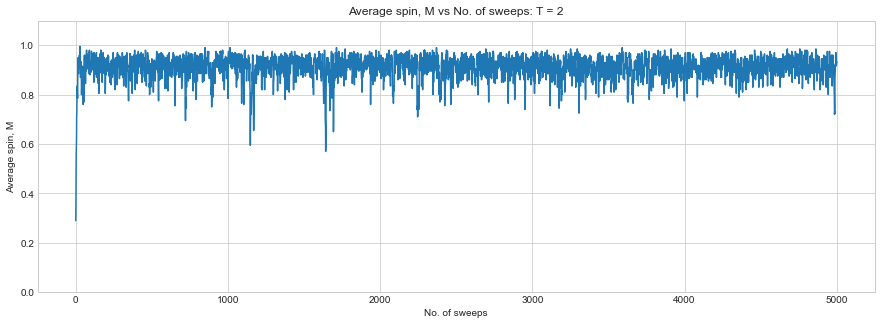

In [30]:
spins_new, E_total_new = sweep_N( spins = spins_old,
                                  n     = 5000,
                                  T     = 2 )

### T = 3

100% |########################################################################|


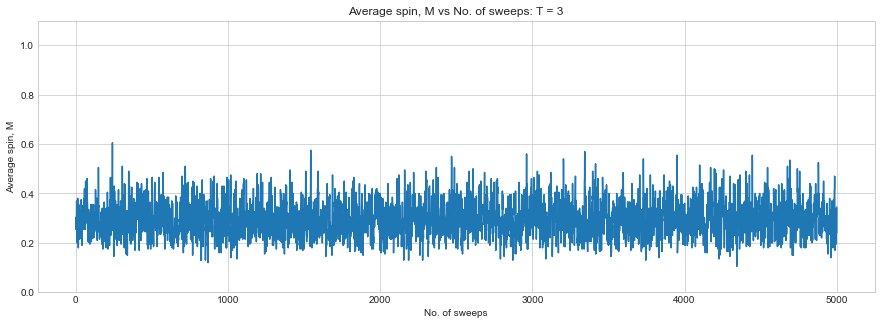

In [31]:
spins_new, E_total_new = sweep_N( spins = spins_old,
                                  n     = 5000,
                                  T     = 3 )

### T = 4

100% |########################################################################|


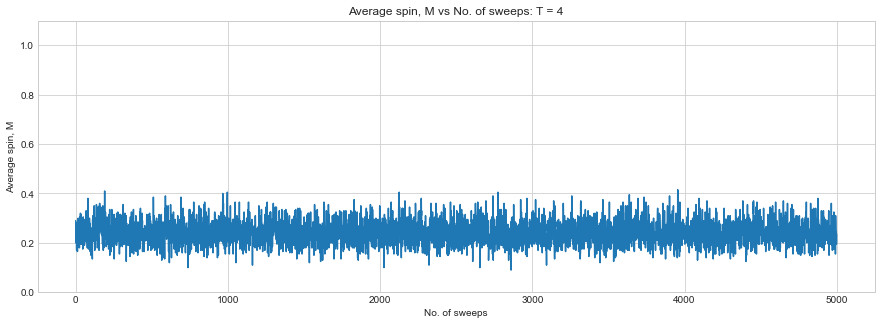

In [32]:
spins_new, E_total_new = sweep_N( spins = spins_old,
                                  n     = 5000,
                                  T     = 4 )

### T = 5

100% |########################################################################|


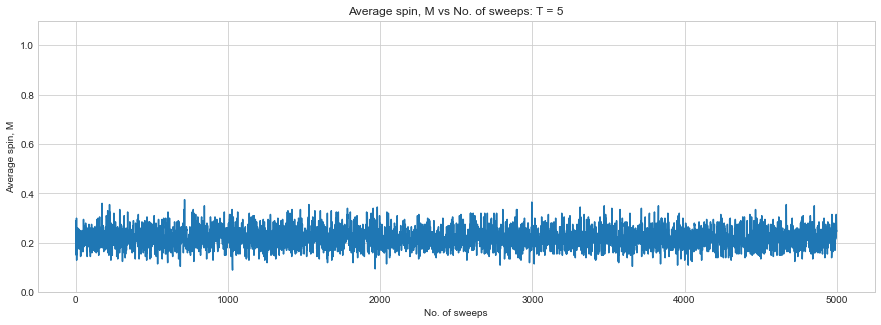

In [33]:
spins_new, E_total_new = sweep_N( spins = spins_old,
                                  n     = 5000,
                                  T     = 5 )

## <span style="color:orange"> 2D Ising model </span>

In [12]:
################################################################################
######################## ising_model_2D ########################################
def ising_model_2D(  size_lattice   = (10, 10),
                     prob_spin_up   = 0.5,
                     period_burnout = 1000,
                     temp_range     = (0.1, 5),
                     n_temp_steps   = 50,
                     N              = 1000 ):
    
    """
    General info:
        This function performs simulation for Ising model of 2D lattice structure.
    Arguments:
        size_lattice   : 2D lattice size
        period_burnout : Burnout period (no. of sweeps) to reach equilibrium state
        temp_range     : Temperature range
        N              : No. of sweeps for the simulation
    """

    from progressbar import ProgressBar
    
    spins_old = get_spin_lattice(   size_lattice = size_lattice,
                                    prob_spin_up = 0.5,
                                    plot_enabled = False )
    
    Ts        = np.linspace(temp_range[0], temp_range[1], num = n_temp_steps)
    len_Ts    = len(Ts)
    spins_new = [np.nan] * len_Ts
    
    # Loop for temperatures >>
    pbar = ProgressBar()
    j    = -1
    for T in pbar(Ts):
        j = j + 1
        # Burnout runs >>    
        spins_eqib, _ = sweep_N( spins = spins_old,
                                 n     = period_burnout,
                                 T     = T,
                                 pbar_enabled = False,
                                 plot_enabled = False )
        # Real N sweeps >>  
        spins_new[j], E_total_new = sweep_N( spins = spins_eqib[-1],
                                          n     = N,
                                          T     = T,
                                          pbar_enabled = False,
                                          plot_enabled = False )
    
    return Ts, spins_new
######################## ising_model_2D ########################################
################################################################################

## <span style="color:orange"> Plotting Tools </span>

In [13]:
################################################################################1>>
######################## plot_magnetisation ####################################
def plot_magnetisation( spins_in,
                        Ts,
                        figsize = (8, 5),
                        enable_best_fit = True ):
    
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MultipleLocator
    from progressbar import ProgressBar
    from scipy.ndimage.filters import gaussian_filter1d
    
    spins_in = np.array(spins_in)
    len_Ts   = len(Ts)
    M_avg    = [np.nan] * len_Ts
    
    # Loop over Ts >>
    pbar = ProgressBar()
    for i, _ in enumerate(pbar(Ts)):
        Ms       = [ abs(np.average(spins)) for spins in spins_in[i] ]
        M_avg[i] = abs(np.average(Ms))
    
    # Plotting magnetization >>
    fig  = plt.figure(figsize = figsize)
    axes = plt.gca()
    axes.plot(Ts, M_avg, label = "Actual |M|")
    # Setting plot elements >>
    axes.set_title(f"{str_spin_average} vs T")
    axes.set_xlabel("T")
    axes.set_ylabel(str_spin_average)
    plt.legend()
    plt.show()
    
    if enable_best_fit:
        # Plotting best-fit magnetization >>
        fig  = plt.figure(figsize = figsize)
        axes = plt.gca()
        M_avg_smoothed = gaussian_filter1d(M_avg, sigma = 6)
        axes.plot(Ts, M_avg_smoothed, label = "Best fit |M|")
        plt.legend()
        plt.show()
        # Plotting slope of best-fit magnetization >>
        fig  = plt.figure(figsize = figsize)
        axes = plt.gca()
        slopes   = [np.nan] * len_Ts
        delta_T  = Ts[1] - Ts[0]      
        slopes = [ (M_avg_smoothed[i+1] - M_avg_smoothed[i]) / delta_T for i in range(len_Ts-1) ]
        axes.plot(Ts[:-1], slopes, label = "Slope of best fit |M|")
        i_max  = np.argmin(slopes) # << index of point where slope is maximum
        T_c    = Ts[i_max]
        plt.axvline(x = T_c, color = "red", label = f"$T_c$ = {T_c:.4f} (minima)")
        # for i in range(0, len_Ts-1):       
        #     if slopes[i] > slopes[i-1] and Ts[i] > 2: # << point where slope starts increasing
        #         T_c = Ts[i]
        #         break
        # plt.axvline(x = T_c, color = "red", label = f"2: $T_c$ = {T_c:.4f}")
        # Setting plot elements >>
        axes.set_title(f"{str_spin_average} vs T")
        axes.set_xlabel("T")
        axes.set_ylabel(str_spin_average)
        # spacing      = 0.2
        # minorLocator = MultipleLocator(spacing)
        # axes.yaxis.set_major_locator(minorLocator)
        # axes.grid(False)
        # axes.grid(which = 'major')
        plt.legend()
        plt.show()
    
    return M_avg, fig
######################## plot_magnetisation ####################################
################################################################################

In [14]:
################################################################################
######################## plot_susceptibility ###################################
def plot_susceptibility( spins_in,
                         Ts,
                         figsize = (8, 5),
                         enable_best_fit = True ):
    
    import matplotlib.pyplot as plt
    from progressbar import ProgressBar
    from scipy.ndimage.filters import gaussian_filter1d
    
    spins_in = np.array(spins_in)
    len_Ts   = len(Ts)
    M_avg    = [np.nan] * len_Ts
    M_sq_avg = [np.nan] * len_Ts
    X        = [np.nan] * len_Ts
    
    # Loop over Ts >>
    pbar = ProgressBar()
    for i, T in enumerate(pbar(Ts)):
        Ms          = [ abs(np.average(spins)) for spins in spins_in[i] ]
        Ms_sq       = np.square(Ms)
        M_avg[i]    = abs(np.average(Ms))
        M_sq_avg[i] = np.average(Ms_sq)
        X[i]        = (M_sq_avg[i] - M_avg[i]**2) / T
    
    # Plotting Results >>
    fig  = plt.figure(figsize = figsize)
    axes = plt.gca()
    axes.plot(Ts, X)
    # axes.plot(Ts, X, label = "actual")
    # if enable_best_fit:
        # X_smoothed = gaussian_filter1d(X, sigma = 2)
        # axes.plot(Ts, X_smoothed, label = "best fit")
    
    # Finding T_c: Maximum of X >>
    if enable_best_fit:
        # i_max = np.argmax(X_smoothed)
        # T_c   = Ts[i_max]
        # plt.axvline(x = T_c, color = "red", label = f"$2: T_c$ = {T_c:.4f}")
        
        i_max = np.argmax(X)
        T_c   = Ts[i_max]
        plt.axvline(x = T_c, color = "red", label = f"$T_c$ = {T_c:.4f}", zorder = 0)
        plt.legend()
    
    # Setting plot elements >>
    str_susceptibility = "Susceptibility (X)"
    axes.set_title(f"{str_susceptibility} vs T")
    axes.set_xlabel("T")
    axes.set_ylabel(str_susceptibility)
    plt.show()
    
    return X
######################## plot_susceptibility ###################################
################################################################################

In [15]:
################################################################################
######################## plot_energy ###########################################
def plot_energy( spins_in,
                 Ts,
                 figsize = (8, 5),
                 enable_best_fit = True ):
    
    import matplotlib.pyplot as plt
    from progressbar import ProgressBar
    from scipy.ndimage.filters import gaussian_filter1d
    
    spins_in = np.array(spins_in)
    len_Ts   = len(Ts)
    E_avg    = [np.nan] * len_Ts
    
    # Loop over Ts >>
    pbar = ProgressBar()
    for i, _ in enumerate(pbar(Ts)):
        Es       = [ get_E_total(spins) for spins in spins_in[i] ]
        E_avg[i] = np.average(Es)
    
    # Plotting Results >>
    fig  = plt.figure(figsize = figsize)
    axes = plt.gca()
    axes.plot(Ts, E_avg, label = "actual")
    if enable_best_fit:
        E_avg_smoothed = gaussian_filter1d(E_avg, sigma = 4)
        axes.plot(Ts, E_avg_smoothed, label = "best fit")
    
    # Finding T_c: The point where the slope increases >>
    if enable_best_fit:
        slopes   = [np.nan] * len_Ts
        delta_T  = Ts[1] - Ts[0]      
        slopes[0] = (E_avg_smoothed[1] - E_avg_smoothed[0]) / delta_T 
        for i in range(1, len_Ts-1):
            slopes[i] = (E_avg_smoothed[i+1] - E_avg_smoothed[i]) / delta_T       
            if slopes[i] < slopes[i-1] and Ts[i] > 2:
                T_c = Ts[i]
                break
        plt.axvline(x = T_c, color = "red", label = f"$T_c$ = {T_c:.4f}")
    
    # Setting plot elements >>
    str_energy = "Energy (E)"
    axes.set_title(f"{str_energy} vs T")
    axes.set_xlabel("T")
    axes.set_ylabel(str_energy)
    plt.legend()
    plt.show()
    
    return E_avg
######################## plot_energy ###########################################
################################################################################

In [11]:
################################################################################
######################## plot_heat_capacity ####################################
def plot_heat_capacity( spins_in,
                        Ts,
                        figsize = (8, 5),
                        enable_best_fit = True ):
    
    import matplotlib.pyplot as plt
    from progressbar import ProgressBar
    from scipy.ndimage.filters import gaussian_filter1d
    
    spins_in = np.array(spins_in)
    len_Ts   = len(Ts)
    E_avg    = [np.nan] * len_Ts
    E_sq_avg = [np.nan] * len_Ts
    C        = [np.nan] * len_Ts
    
    # Loop over Ts >>
    pbar = ProgressBar()
    for i, T in enumerate(pbar(Ts)):
        Es          = [ get_E_total(spins) for spins in spins_in[i] ]
        Es_sq       = np.square(Es)
        # E_avg[i]    = abs(np.average(Es))
        E_avg[i]    = np.average(Es)
        E_sq_avg[i] = np.average(Es_sq)
        C[i]        = (E_sq_avg[i] - E_avg[i]**2) / T**2
    
    # Plotting Results >>
    fig  = plt.figure(figsize = figsize)
    axes = plt.gca()
    axes.plot(Ts, C, label = "actual")
    if enable_best_fit:
        C_smoothed = gaussian_filter1d(C, sigma = 2)
        axes.plot(Ts, C_smoothed, label = "best fit")
    
    # Finding T_c: Maximum of C >>
    if enable_best_fit:
        i_max = np.argmax(C_smoothed)
        T_c   = Ts[i_max]
        plt.axvline(x = T_c, color = "red", label = f"2: $T_c$ = {T_c:.4f}")
        i_max = np.argmax(C)
        T_c   = Ts[i_max]
        plt.axvline(x = T_c, color = "blue", label = f"1: $T_c$ = {T_c:.4f}", zorder = 0)
    
    # Setting plot elements >>
    str_heat_capacity = "Heat capacity (C)"
    axes.set_title(f"{str_heat_capacity} vs T")
    axes.set_xlabel("T")
    axes.set_ylabel(str_heat_capacity)
    plt.legend()
    plt.show()
    
    return C
######################## plot_heat_capacity ####################################
################################################################################

In [14]:
################################################################################
######################## plot_M_and_X ##########################################
def plot_M_and_X( spins_in,
                  Ts,
                  figsize = (8, 5),
                  enable_best_fit = True,
                  lim_x           = (None, None) ):
    
    import matplotlib.pyplot as plt
    from progressbar import ProgressBar
    from scipy.ndimage.filters import gaussian_filter1d
    
    # spins_in = np.array(spins_in)
    len_Ts   = len(Ts)
    M_avg    = [np.nan] * len_Ts
    M_sq_avg = [np.nan] * len_Ts
    X        = [np.nan] * len_Ts
    
    # Calculating M_avg & X: Loop over Ts >>
    pbar = ProgressBar()
    for i, T in enumerate(pbar(Ts)):
        Ms          = [ abs(np.average(spins)) for spins in spins_in[i] ]
        Ms_sq       = np.square(Ms)
        M_avg[i]    = abs(np.average(Ms))
        M_sq_avg[i] = np.average(Ms_sq)
        X[i]        = (M_sq_avg[i] - M_avg[i]**2) / T
    
    # Plotting results >>
    figs = [np.nan] * 4
    axes = [np.nan] * 4
    
    # Plotting M_avg >>
    figs[0] = plt.figure(figsize = figsize)
    axes[0] = plt.gca()
    axes[0].plot(Ts, M_avg, label = "M")
    axes[0].set_title(f"{str_spin_average} vs T")
    axes[0].set_xlabel("T")
    axes[0].set_ylabel(str_spin_average)
    axes[0].set_xlim( (lim_x[0], lim_x[1]) )
    axes[0].legend()
    plt.show()
    
    # Plotting best fit M_avg >>
    if enable_best_fit:
        figs[1] = plt.figure(figsize = figsize)
        axes[1] = plt.gca()
        M_avg_smoothed = gaussian_filter1d(M_avg, sigma = 6)
        str_best_fit_M = f"Best fit M"
        axes[1].plot(Ts, M_avg_smoothed, label = str_best_fit_M)
        axes[1].set_title(f"{str_best_fit_M} vs T")
        axes[1].set_xlabel("T")
        axes[1].set_ylabel(str_best_fit_M)
        axes[1].set_xlim( (lim_x[0], lim_x[1]) )
        axes[1].legend()
        plt.show()
        
    # Plotting slope of best-fit M_avg >>
    if enable_best_fit:
        figs[2] = plt.figure(figsize = figsize)
        axes[2] = plt.gca()
        delta_T = Ts[1] - Ts[0]      
        slopes  = [ (M_avg_smoothed[i+1] - M_avg_smoothed[i]) / delta_T for i in range(len_Ts-1) ]
        str_m_M = f"$m_M$"
        str_slope_of_best_fit_M = "Slope of " + str_best_fit_M + f", {str_m_M}"
        axes[2].plot(Ts[:-1], slopes, label = str_m_M)
        i_max   = np.argmin(slopes)     # << index of max slope
        T_c     = Ts[i_max]
        axes[2].axvline(x = T_c, color = "red", label = f"$T_c$ = {T_c:.4f} (minima)", zorder = 0)
        axes[2].set_title(f"{str_slope_of_best_fit_M} vs T")
        axes[2].set_xlabel("T")
        axes[2].set_ylabel(str_slope_of_best_fit_M)
        axes[2].set_xlim( (lim_x[0], lim_x[1]) )
        axes[2].legend()
        plt.show()
    
    # Plotting X >>
    figs[3] = plt.figure(figsize = figsize)
    axes[3] = plt.gca()
    str_chi = '$\chi$'
    axes[3].plot(Ts, X, label = str_chi)
    i_max   = np.argmax(X)
    T_c     = Ts[i_max]
    axes[3].axvline(x = T_c, color = "red", label = f"$T_c$ = {T_c:.4f}", zorder = 0)
    str_susceptibility = f"Magnetic susceptibility, {str_chi}"
    axes[3].set_title(f"{str_susceptibility} vs T")
    axes[3].set_xlabel("T")
    axes[3].set_ylabel(str_susceptibility)
    axes[3].set_xlim( (lim_x[0], lim_x[1]) )
    axes[3].legend()
    plt.show()
    
    return M_avg, X, figs
######################## plot_M_and_X ##########################################
################################################################################

In [15]:
################################################################################
######################## plot_E_and_C ##########################################
def plot_E_and_C( spins_in,
                  Ts,
                  figsize         = (8, 5),
                  enable_best_fit = True,
                  lim_x           = (None, None) ):
    
    import matplotlib.pyplot as plt
    from progressbar import ProgressBar
    from scipy.ndimage.filters import gaussian_filter1d
    
    # spins_in = np.array(spins_in)
    len_Ts   = len(Ts)
    E_avg    = [np.nan] * len_Ts
    E_sq_avg = [np.nan] * len_Ts
    C        = [np.nan] * len_Ts
    
    # Calculating E_avg & C: Loop over Ts >>
    pbar = ProgressBar()
    for i, T in enumerate(pbar(Ts)):
        Es          = [ get_E_total(spins) for spins in spins_in[i] ]
        Es_sq       = np.square(Es)
        # E_avg[i]    = abs(np.average(Es))
        E_avg[i]    = np.average(Es)
        E_sq_avg[i] = np.average(Es_sq)
        C[i]        = (E_sq_avg[i] - E_avg[i]**2) / T**2
    
    # Plotting results >>
    figs = [np.nan] * 4
    axes = [np.nan] * 4
    
    # Plotting E_avg >>
    figs[0]    = plt.figure(figsize = figsize)
    axes[0]    = plt.gca()
    axes[0].plot(Ts, E_avg, label = "E")
    str_energy = "Energy, E"
    axes[0].set_title(f"{str_energy} vs T")
    axes[0].set_xlabel("T")
    axes[0].set_ylabel(str_energy)
    axes[0].set_xlim( (lim_x[0], lim_x[1]) )
    axes[0].legend()
    plt.show()
    
    # Plotting best fit E_avg >>
    if enable_best_fit:
        figs[1] = plt.figure(figsize = figsize)
        axes[1] = plt.gca()
        E_avg_smoothed = gaussian_filter1d(E_avg, sigma = 4)
        str_best_fit_E = f"Best fit E"
        axes[1].plot(Ts, E_avg_smoothed, label = str_best_fit_E)
        axes[1].set_title(f"{str_best_fit_E} vs T")
        axes[1].set_xlabel("T")
        axes[1].set_ylabel(str_best_fit_E)
        axes[1].set_xlim( (lim_x[0], lim_x[1]) )
        axes[1].legend()
        plt.show()
        
    # Plotting slope of best-fit E_avg >>
    if enable_best_fit:
        figs[2] = plt.figure(figsize = figsize)
        axes[2] = plt.gca()
        delta_T = Ts[1] - Ts[0]      
        slopes  = [ (E_avg_smoothed[i+1] - E_avg_smoothed[i]) / delta_T for i in range(len_Ts-1) ]
        str_m_E = f"$m_E$"
        str_slope_of_best_fit_E = "Slope of " + str_best_fit_E + f", {str_m_E}"
        axes[2].plot(Ts[:-1], slopes, label = str_m_E)
        i_max   = np.argmax(slopes)     # << index of max slope
        T_c     = Ts[i_max]
        axes[2].axvline(x = T_c, color = "red", label = f"$T_c$ = {T_c:.4f} (maxima)", zorder = 0)
        axes[2].set_title(f"{str_slope_of_best_fit_E} vs T")
        axes[2].set_xlabel("T")
        axes[2].set_ylabel(str_slope_of_best_fit_E)
        axes[2].set_xlim( (lim_x[0], lim_x[1]) )
        axes[2].legend()
        plt.show()
    
    # Plotting C >>
    figs[3] = plt.figure(figsize = figsize)
    axes[3] = plt.gca()
    str_C = '$C$'
    axes[3].plot(Ts, C, label = str_C)
    i_max   = np.argmax(C)
    T_c     = Ts[i_max]
    axes[3].axvline(x = T_c, color = "red", label = f"$T_c$ = {T_c:.4f}", zorder = 0)
    str_heat_capacity = f"Heat capacity, {str_C}"
    axes[3].set_title(f"{str_heat_capacity} vs T")
    axes[3].set_xlabel("T")
    axes[3].set_ylabel(str_heat_capacity)
    axes[3].set_xlim( (lim_x[0], lim_x[1]) )
    axes[3].legend()
    plt.show()
    
    return E_avg, C, figs
######################## plot_E_and_C ##########################################
################################################################################

In [16]:
################################################################################
######################## save_variables_to_file ################################
def save_variables_to_file(variables, file_pkl):
    import pickle
    from datetime import datetime
    filename = datetime.today().strftime("%Y%m%d_%H%M%S") + "_" + file_pkl
    with open(filename, 'wb') as f:
        pickle.dump(variables, f)
    return None
######################## save_variables_to_file ################################
################################################################################

In [17]:
################################################################################
######################## load_variables_from_file ##############################
def load_variables_from_file(file_pkl):
    import pickle
    with open(file_pkl, 'rb') as f:
        variables = pickle.load(f)
    return variables
######################## load_variables_from_file ##############################
################################################################################

## <span style="color:green"> Final Solution </span>

# 20 x 20 lattice

In [18]:
Ts, spins_new = ising_model_2D( size_lattice   = (20, 20),
                                prob_spin_up   = 0.5,
                                period_burnout = 5000,
                                temp_range     = (0.1, 5),
                                n_temp_steps   = 300,
                                N              = 1000 )

100% |########################################################################|


In [19]:
# Saving variable to .pkl file >>
save_variables_to_file( [spins_new, Ts], "spins_new_Ts_20x20.pkl" )

In [20]:
# import os
# files    = os.listdir()
# filename = [ file for file in files if file.startswith("20210918") ]
# filename[0]

'20210918_154856_spins_new_Ts_20x20.pkl'

### Run 1: 20 x 20 lattice

In [25]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/20x20/20210915_173535_spins_new_Ts_20x20.pkl")

100% |########################################################################|


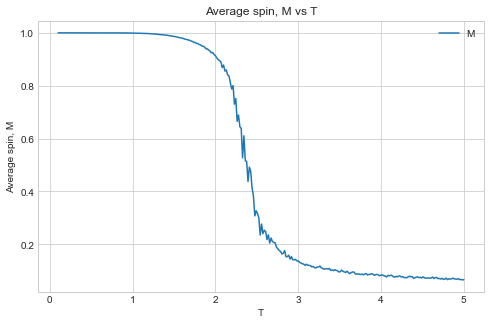

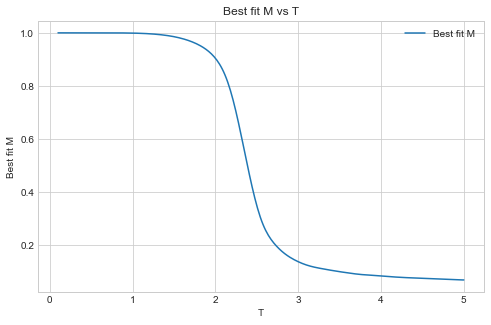

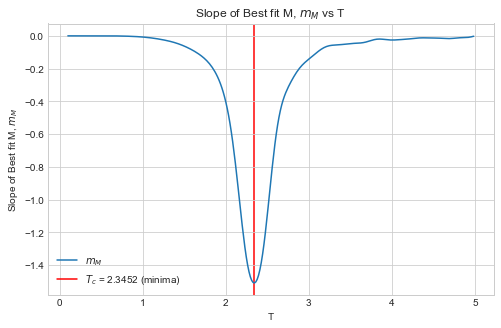

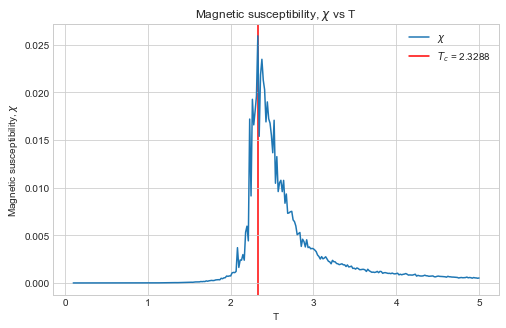

In [26]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


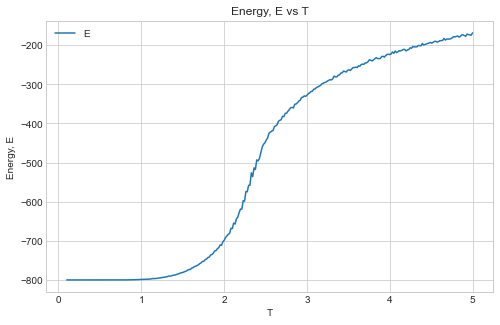

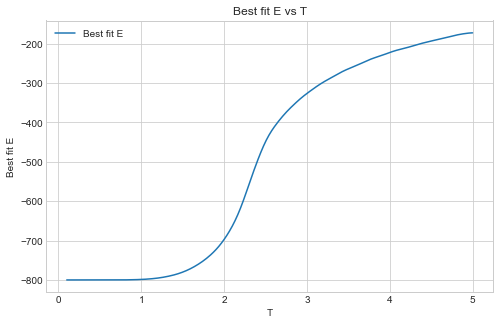

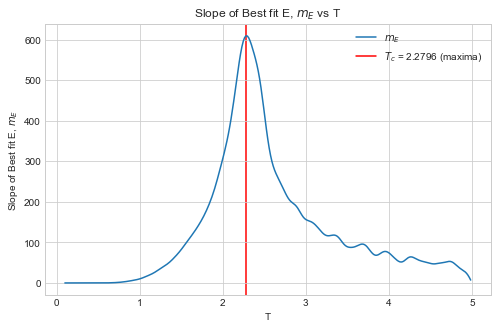

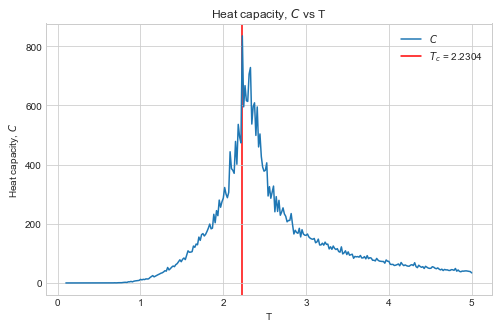

In [27]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

### Run 2: 20 x 20 lattice

In [28]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/20x20/20210916_050109_spins_new_Ts_20x20.pkl")

100% |########################################################################|


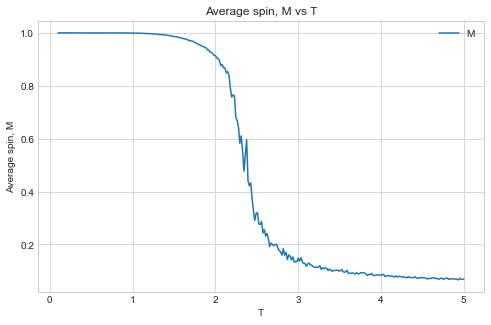

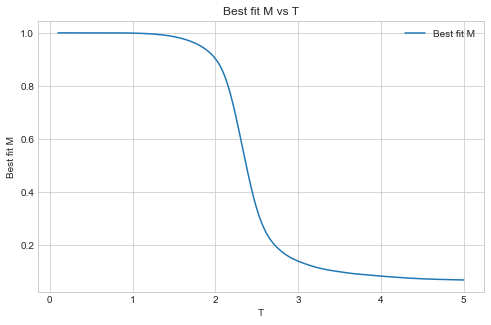

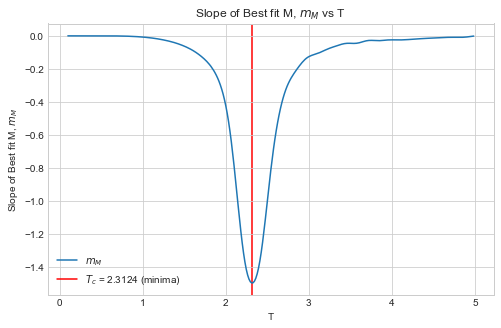

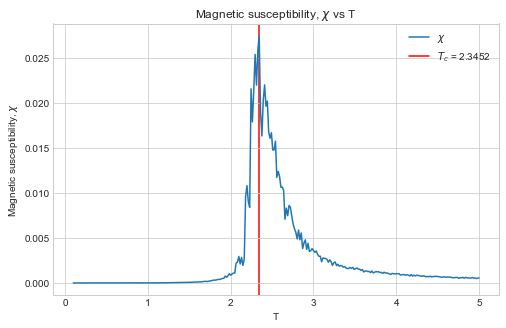

In [29]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


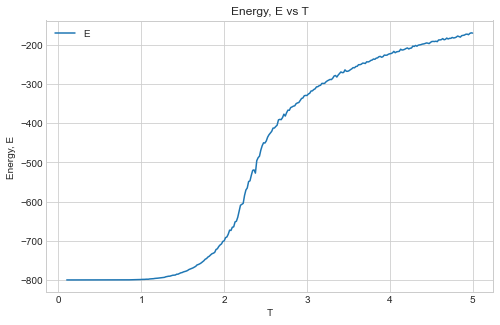

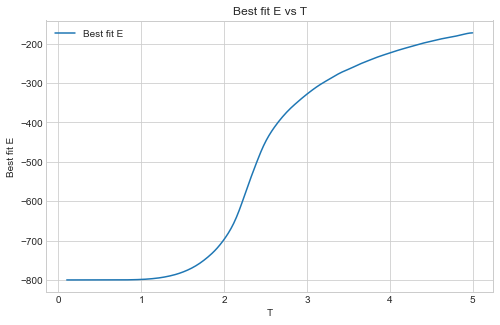

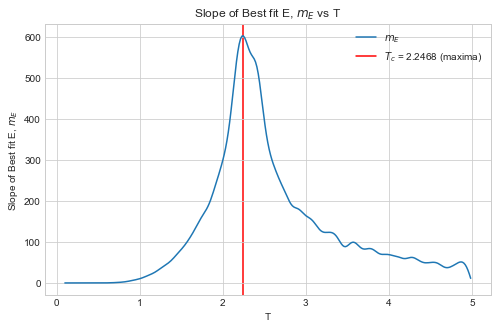

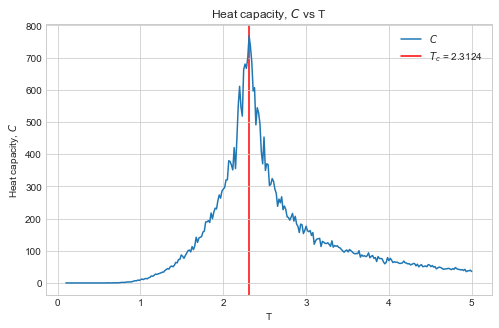

In [30]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

### Run 3: 20 x 20 lattice

In [31]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/20x20/20210916_215438_spins_new_Ts_20x20.pkl")

100% |########################################################################|


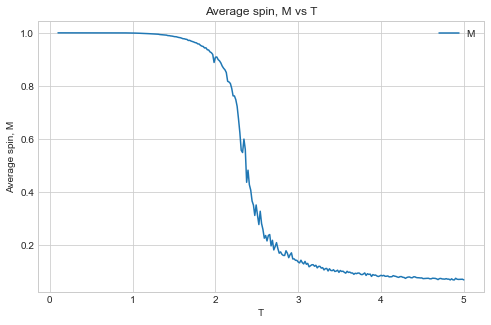

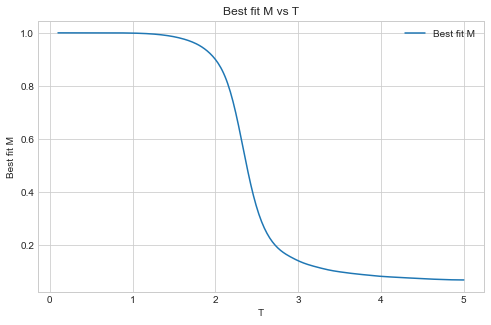

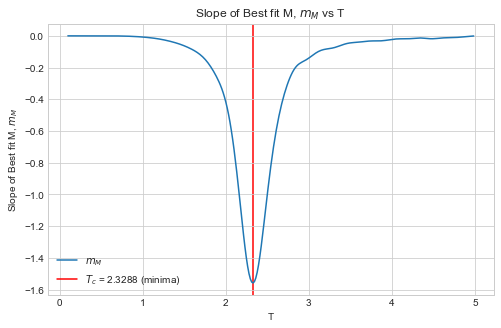

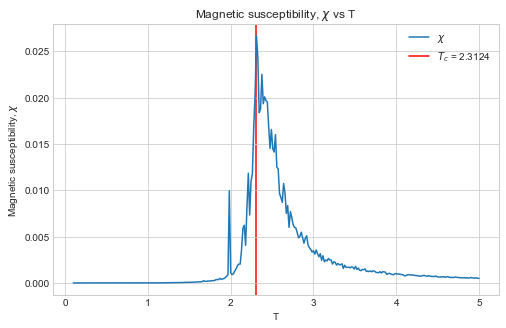

In [32]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


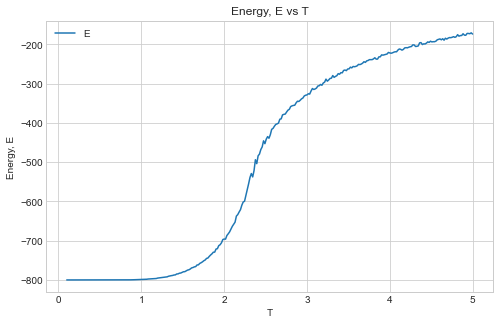

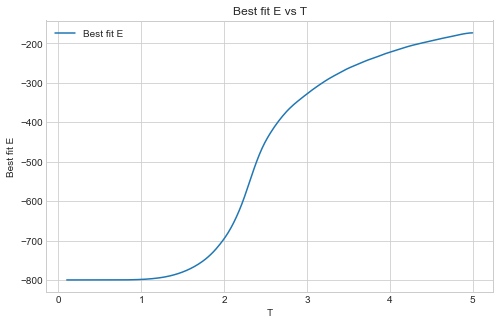

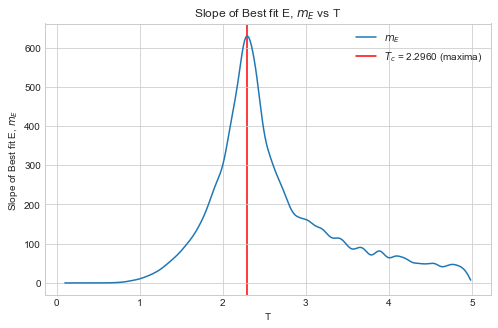

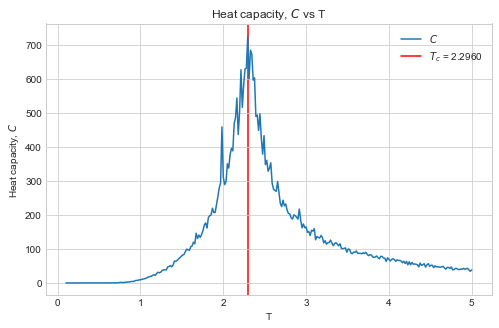

In [33]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

### Run 4: 20 x 20 lattice

In [31]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/20x20/20210917_052928_spins_new_Ts_20x20.pkl")

100% |########################################################################|


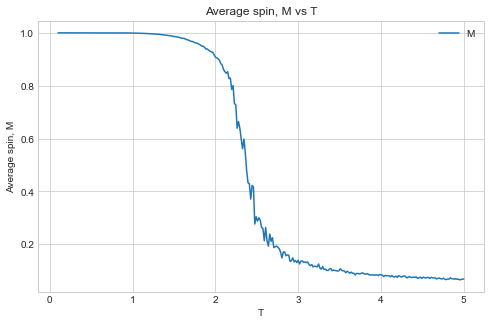

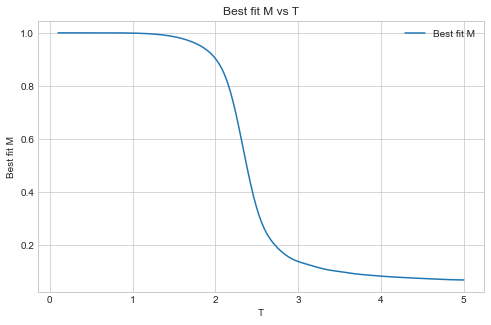

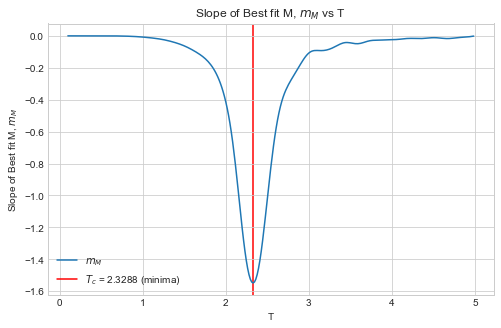

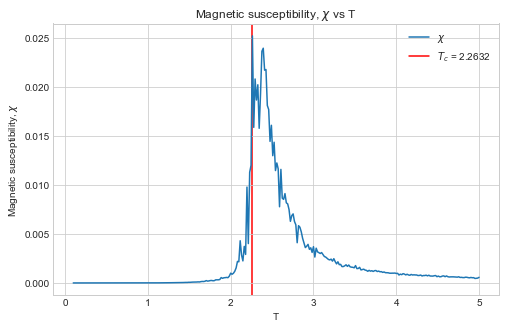

In [39]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


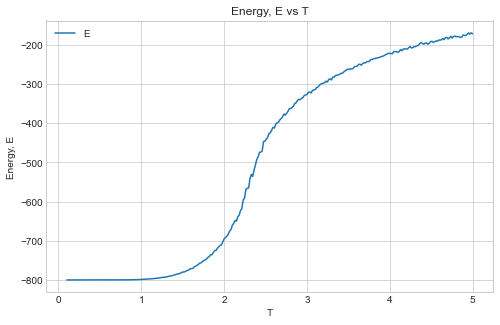

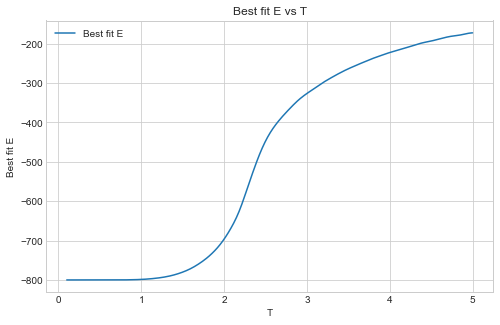

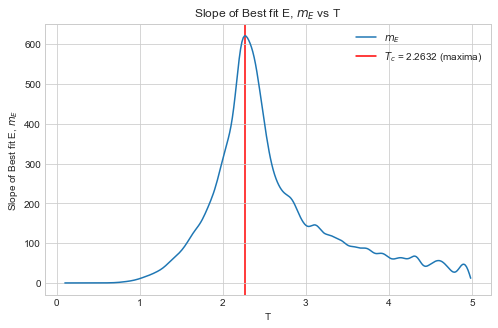

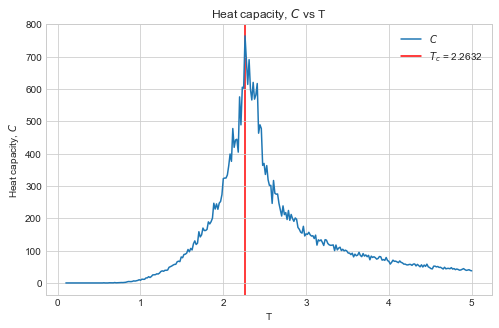

In [40]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

### Run 5: 20 x 20 lattice

In [21]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/20x20/20210918_154856_spins_new_Ts_20x20.pkl")

100% |########################################################################|


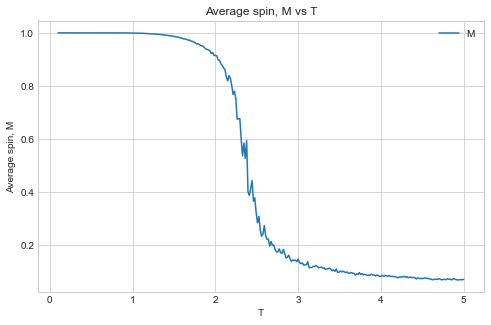

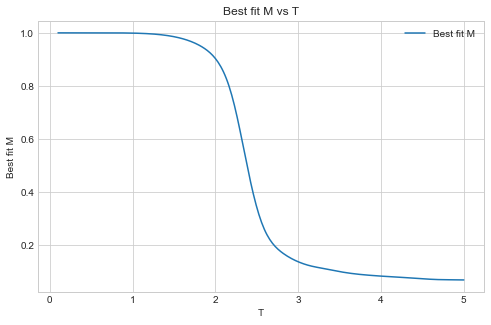

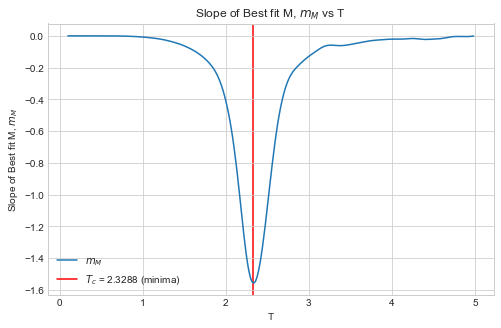

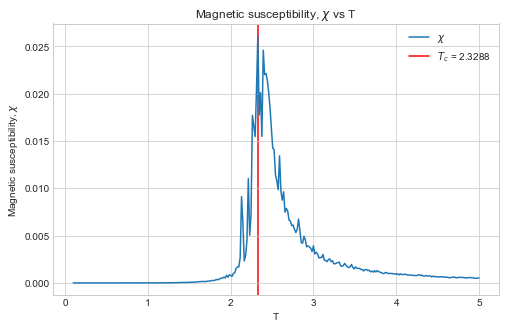

In [23]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


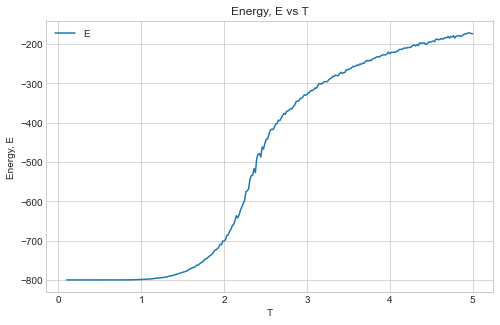

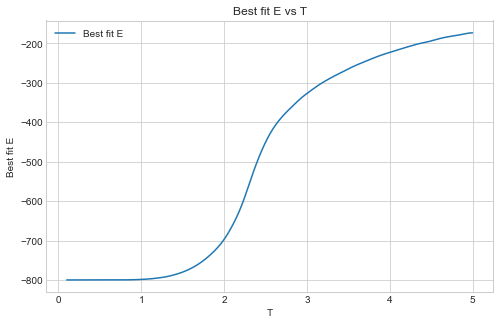

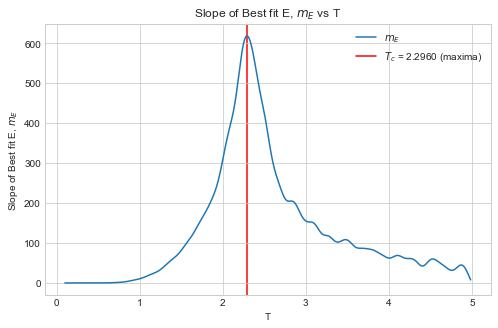

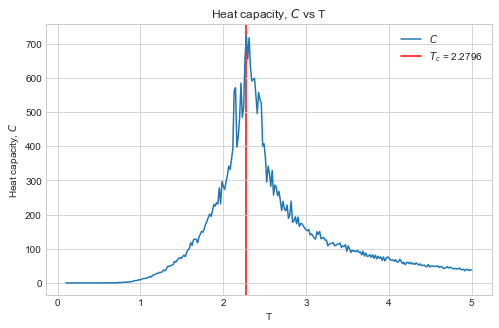

In [24]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

In [25]:
Tc_20x20 = [2.2304, 2.3124, 2.3960, 2.2632, 2.2796]

# 5 x 5 lattice

In [36]:
Ts, spins_new = ising_model_2D( size_lattice   = (5, 5),
                                prob_spin_up   = 0.5,
                                period_burnout = 5000,
                                temp_range     = (0.1, 5),
                                n_temp_steps   = 300,
                                N              = 1000 )

100% |########################################################################|


In [37]:
# Saving variable to .pkl file >>
save_variables_to_file( [spins_new, Ts], "spins_new_Ts_5x5.pkl" )

### Run 1: 5 x 5 lattice

In [24]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/5x5/20210917_054202_spins_new_Ts_5x5.pkl")

100% |########################################################################|


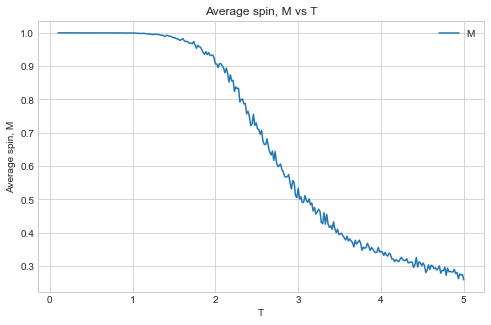

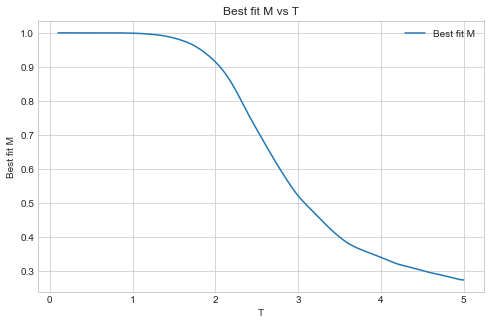

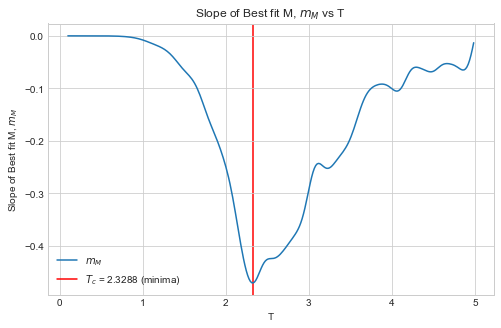

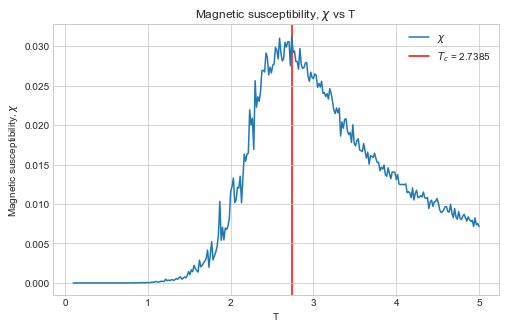

In [53]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


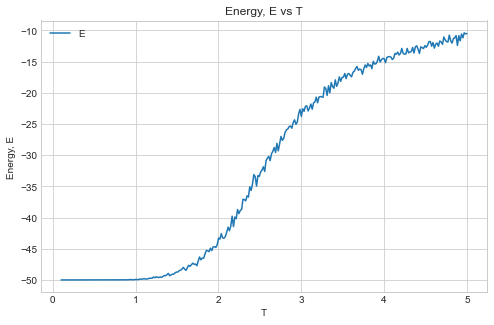

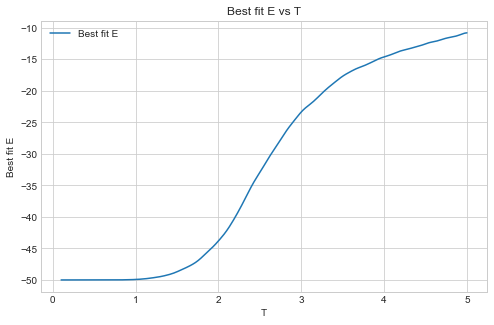

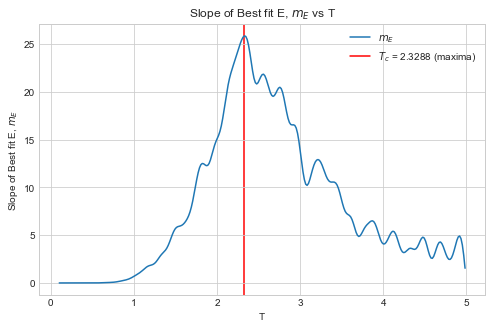

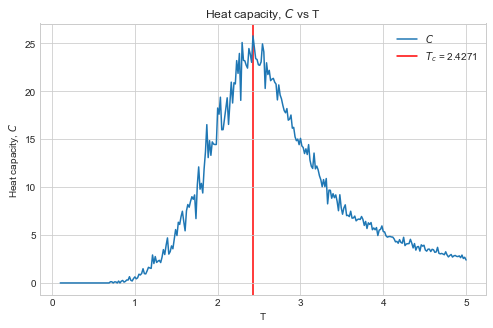

In [54]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

### Run 2: 5 x 5 lattice

In [24]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/5x5/20210917_224714_spins_new_Ts_5x5.pkl")

100% |########################################################################|


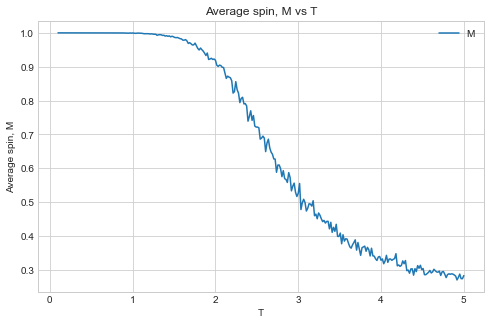

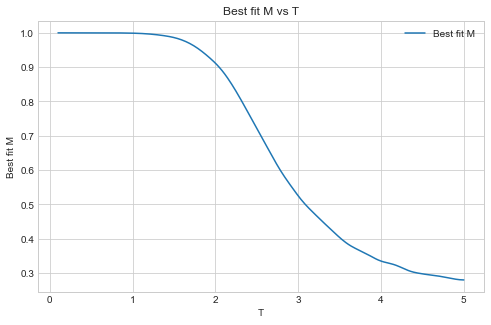

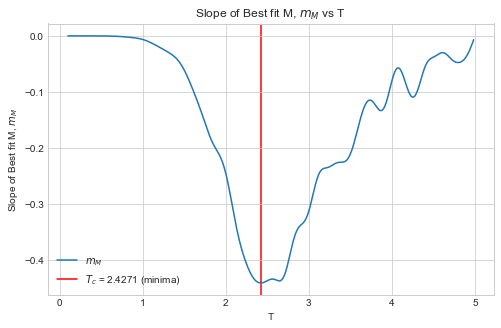

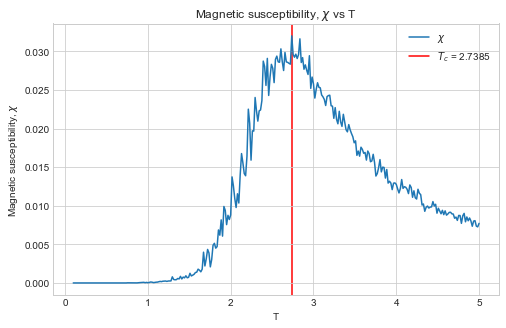

In [25]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


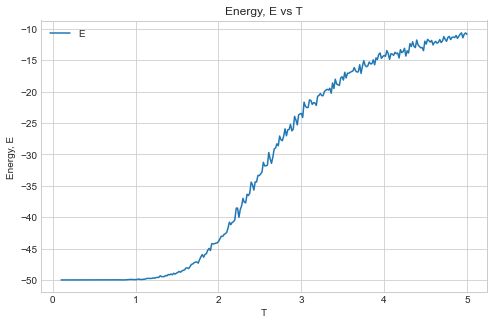

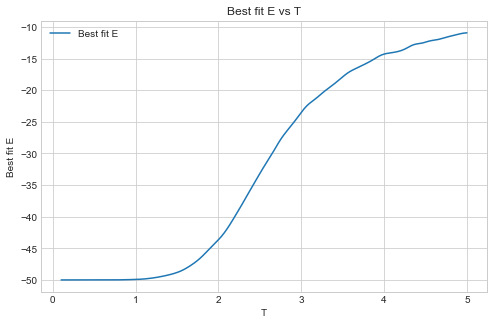

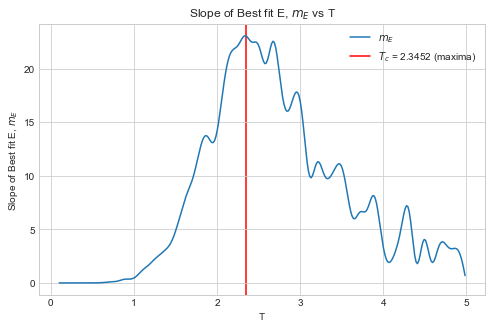

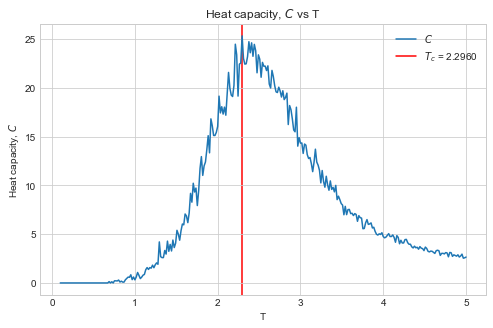

In [26]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

### Run 3: 5 x 5 lattice

In [38]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/5x5/20210918_132440_spins_new_Ts_5x5.pkl")

100% |########################################################################|


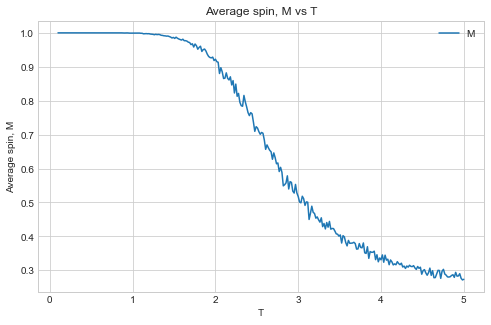

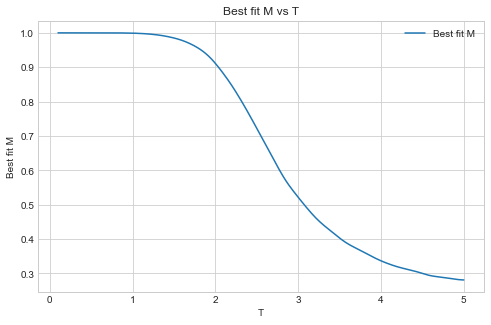

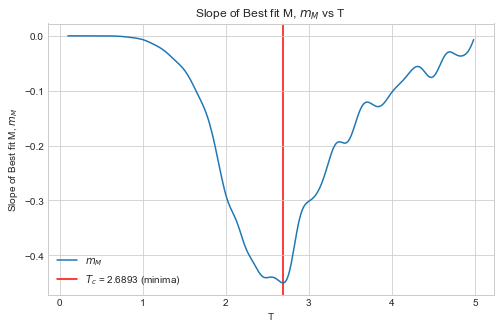

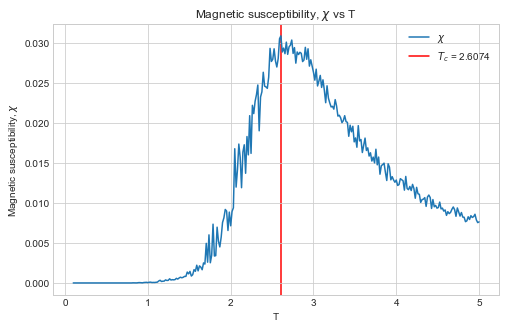

In [40]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


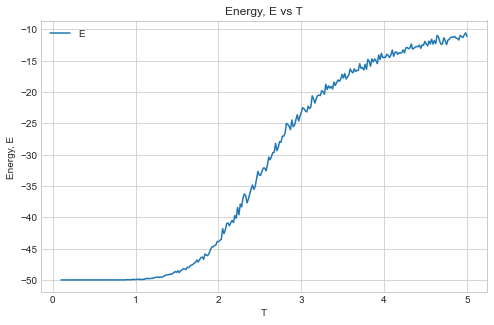

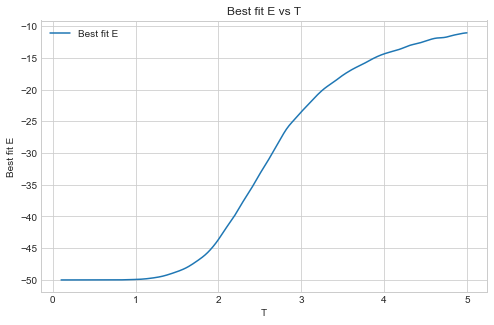

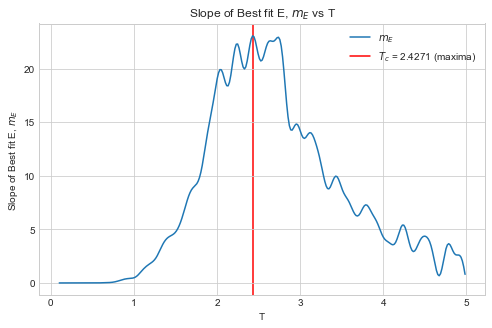

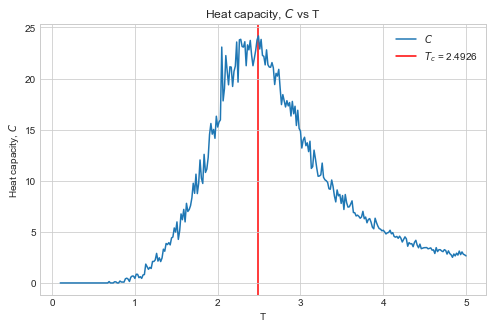

In [39]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

In [27]:
Tc_5x5 = [2.4271, 2.2960, 2.4926]

# 10 x 10

In [27]:
Ts, spins_new = ising_model_2D( size_lattice   = (10, 10),
                                prob_spin_up   = 0.5,
                                period_burnout = 5000,
                                temp_range     = (0.1, 5),
                                n_temp_steps   = 300,
                                N              = 1000 )

100% |########################################################################|


In [32]:
# Saving variable to .pkl file >>
save_variables_to_file( [spins_new, Ts], "spins_new_Ts_10x10.pkl" )

### Run 1: 10 x 10 lattice

In [55]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/10x10/20210917_061238_spins_new_Ts_10x10.pkl")

100% |########################################################################|


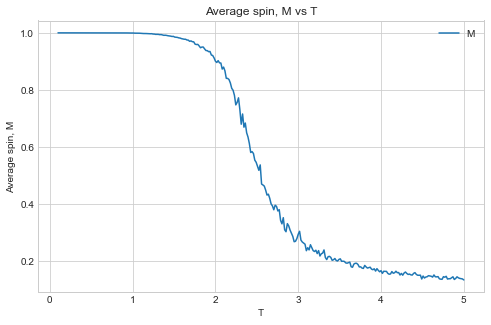

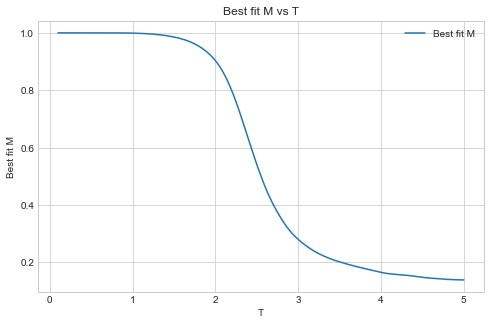

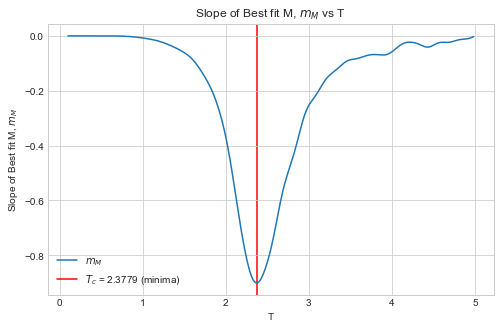

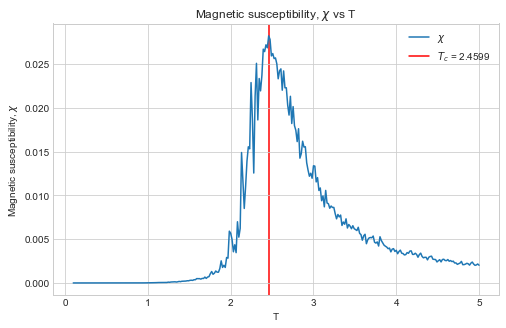

In [56]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


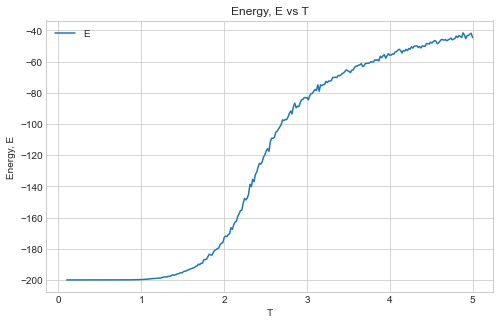

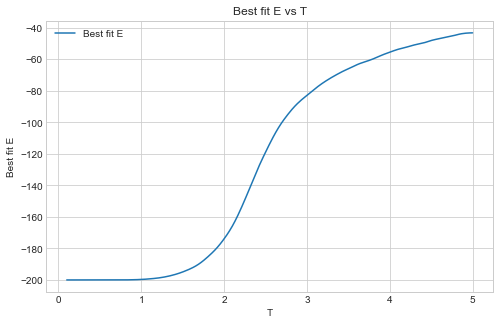

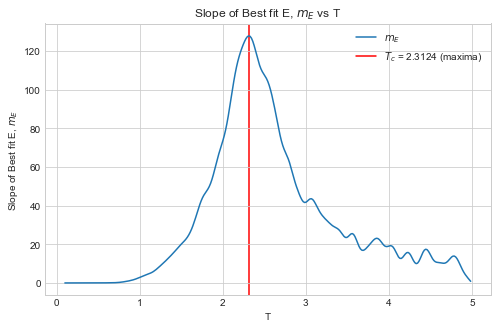

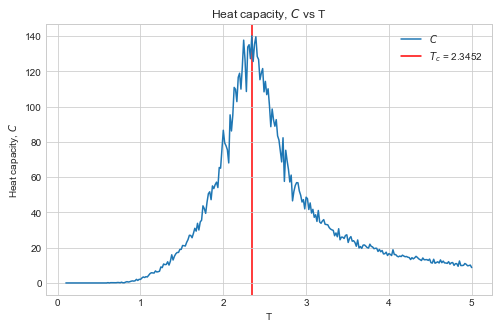

In [57]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

### Run 2: 10 x 10 lattice

In [33]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/10x10/20210917_233703_spins_new_Ts_10x10.pkl")

100% |########################################################################|


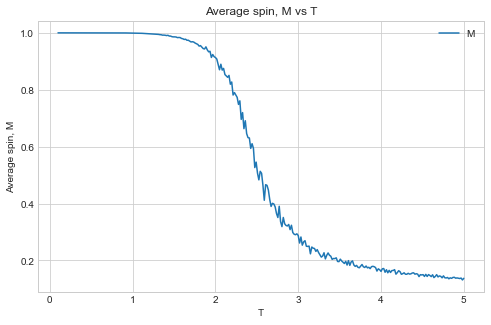

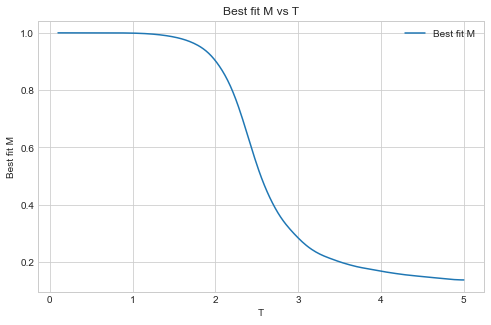

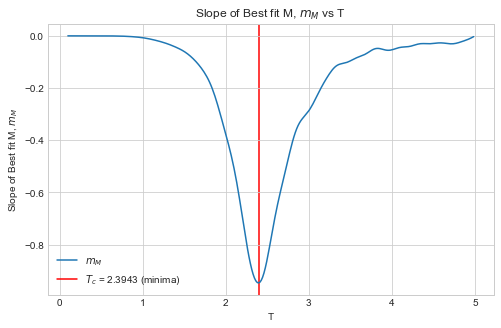

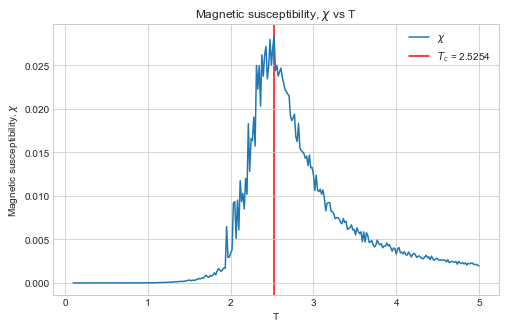

In [34]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


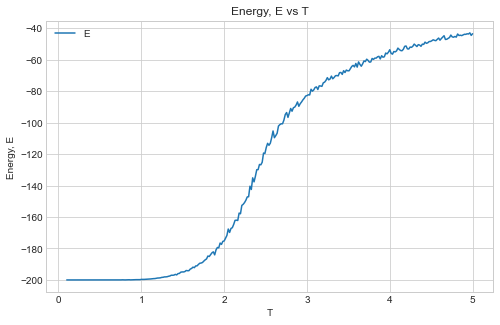

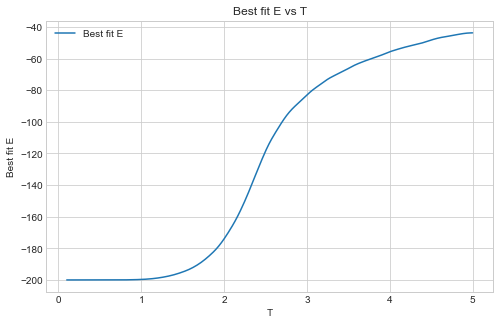

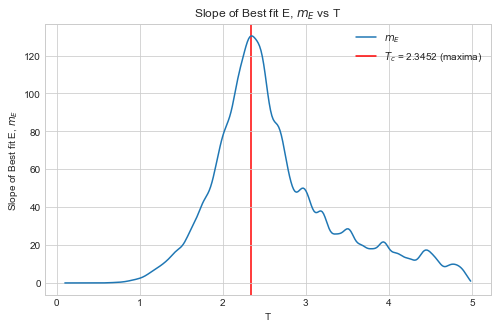

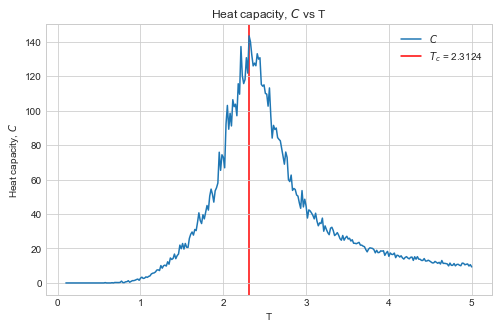

In [35]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

In [28]:
Tc_10x10 = [2.3452, 2.3124]

# 15 x 15

In [39]:
Ts, spins_new = ising_model_2D( size_lattice   = (15, 15),
                                prob_spin_up   = 0.5,
                                period_burnout = 5000,
                                temp_range     = (0.1, 5),
                                n_temp_steps   = 300,
                                N              = 1000 )

100% |########################################################################|


In [40]:
# Saving variable to .pkl file >>
save_variables_to_file( [spins_new, Ts], "spins_new_Ts_15x15.pkl" )

### Run 1: 15 x 15 lattice

In [35]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/15x15/20210917_072657_spins_new_Ts_15x15.pkl")

In [ ]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

In [ ]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

### Run 2: 15 x 15 lattice

In [29]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/15x15/20210918_005156_spins_new_Ts_15x15.pkl")

100% |########################################################################|


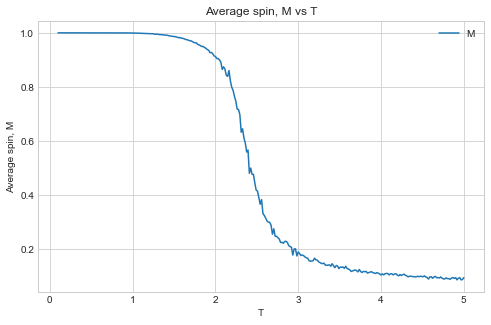

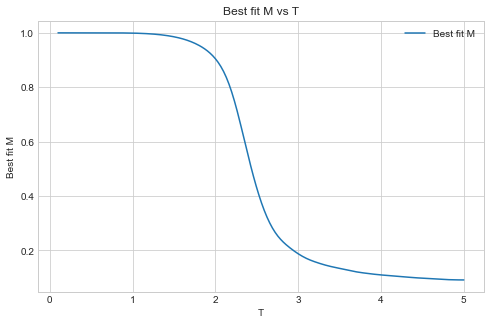

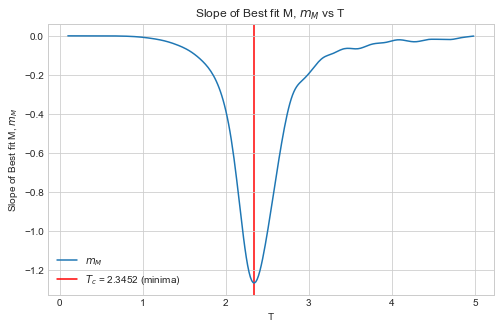

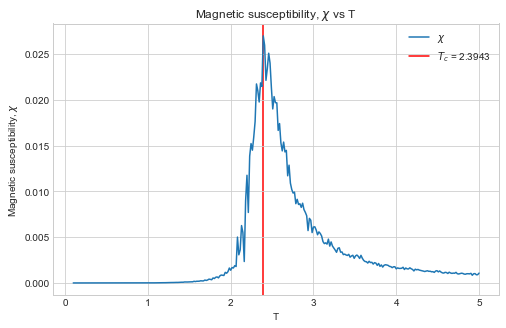

In [30]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


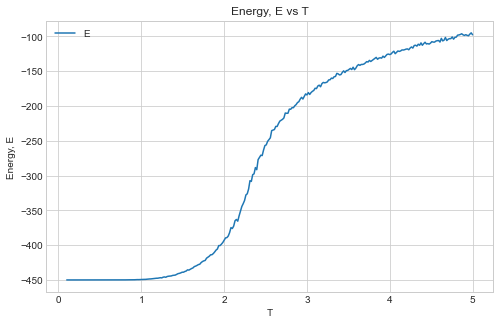

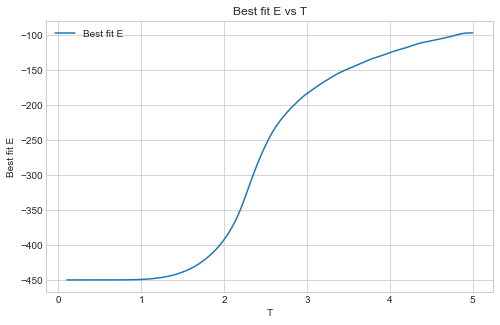

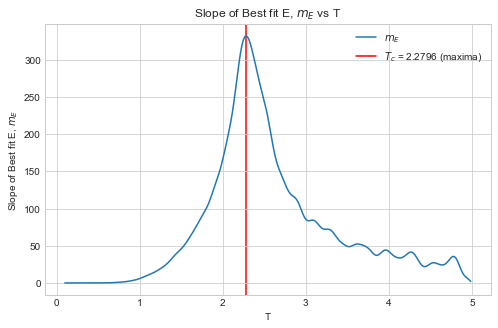

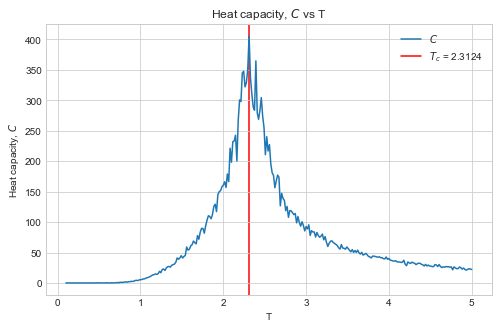

In [31]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

In [ ]:
Tc_15x15 = [2.3288, 2.3124]

In [ ]:
print(f"Tc(5 x 5) : {Tc_5x5})")
print(f"Tc(10x10) : {Tc_10x10})")
print(f"Tc(15x15) : {Tc_15x15})")
print(f"Tc(20x20) : {Tc_20x20})")
print(f"Tc(25x25) : {Tc_25x25})")

# 25 x 25

In [30]:
Ts, spins_new = ising_model_2D( size_lattice   = (25, 25),
                                prob_spin_up   = 0.5,
                                period_burnout = 2000,
                                temp_range     = (0.1, 5),
                                n_temp_steps   = 300,
                                N              = 1000 )

100% |########################################################################|


In [31]:
# Saving variable to .pkl file >>
save_variables_to_file( [spins_new, Ts], "spins_new_Ts_25x25.pkl" )

### Run 1: 25 x 25 lattice

In [52]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/25x25/20210917_091005_spins_new_Ts_25x25.pkl")

100% |########################################################################|


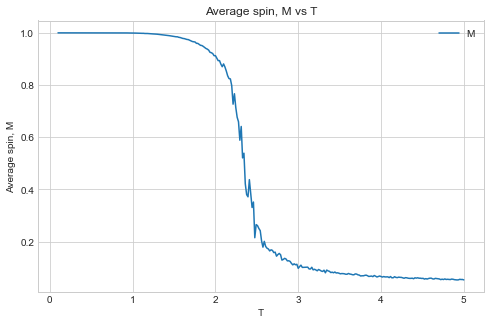

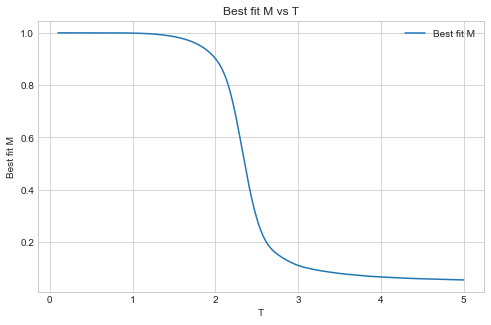

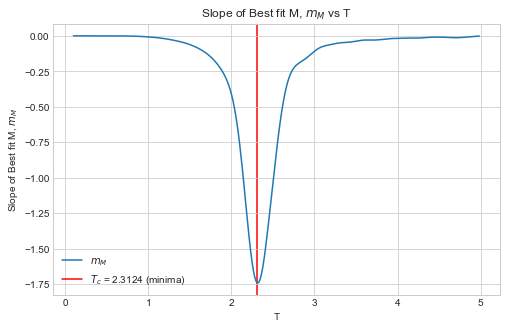

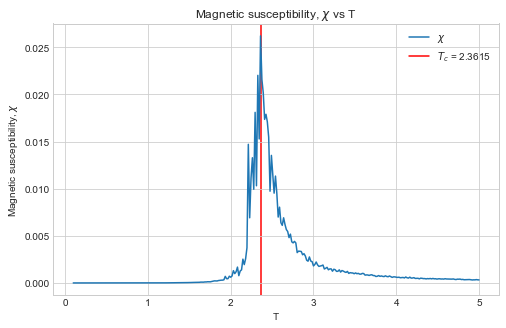

In [53]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

100% |########################################################################|


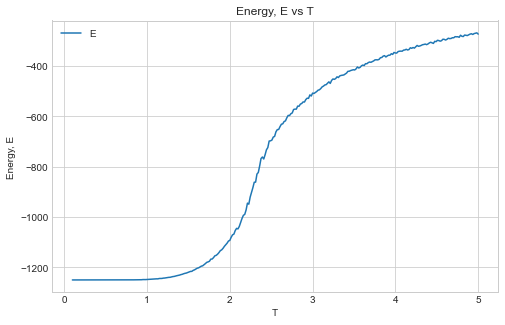

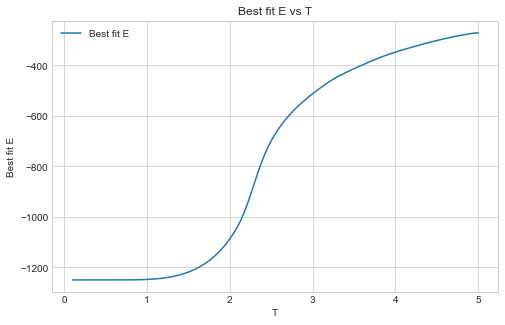

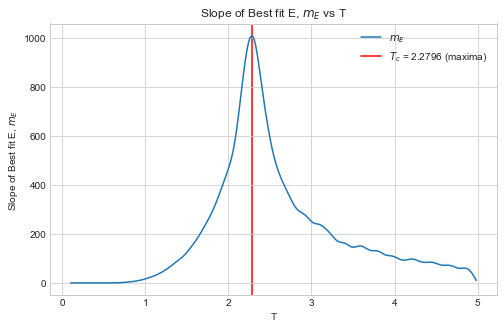

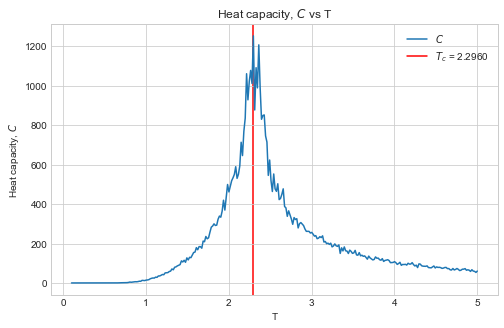

In [55]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp,
                               Ts_loaded_temp,
                               figsize = (8, 5) )

### Run 2: 25 x 25 lattice

In [32]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/25x25/20210918_125632_spins_new_Ts_25x25.pkl")

100% |########################################################################|


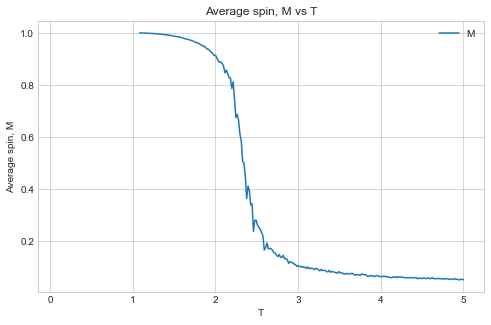

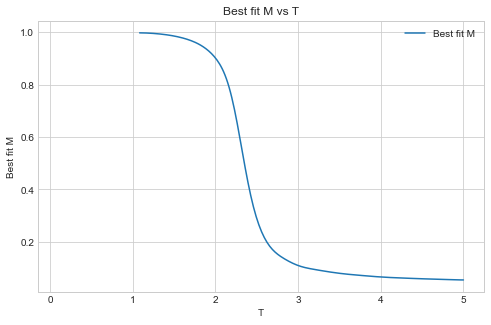

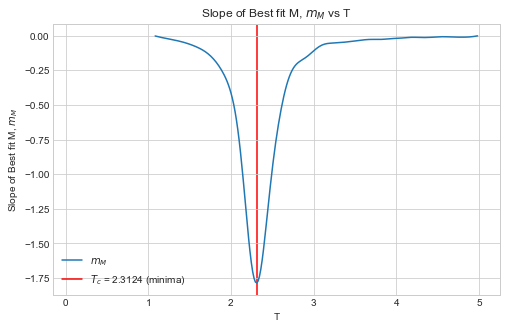

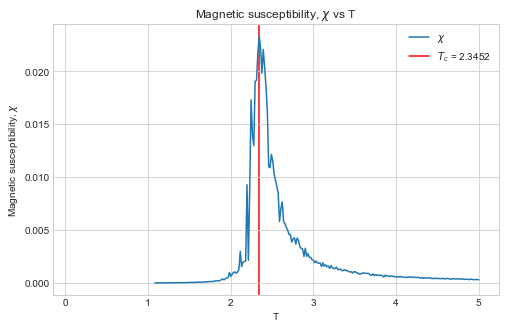

In [33]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp[60:],
                               Ts_loaded_temp[60:],
                               figsize = (8, 5),
                               lim_x   = (-0.15, 5.25) )

100% |########################################################################|


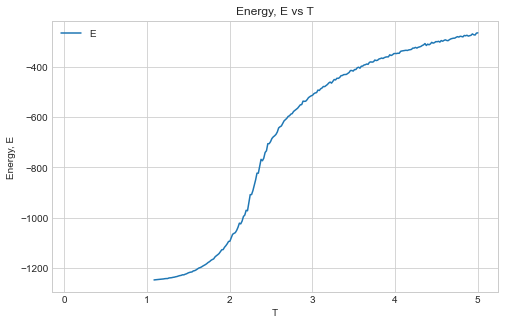

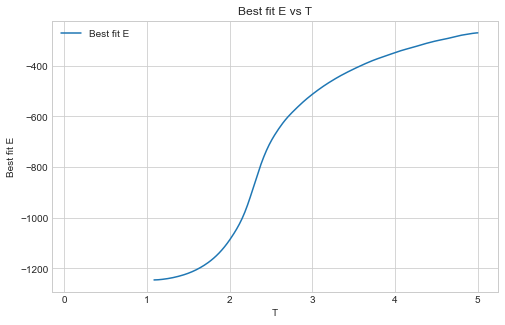

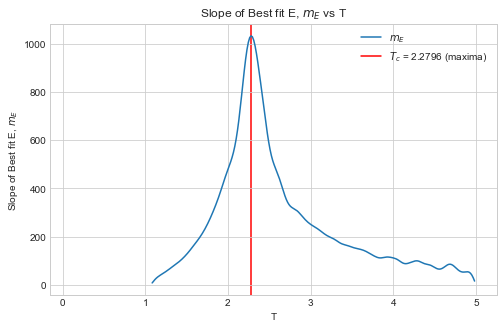

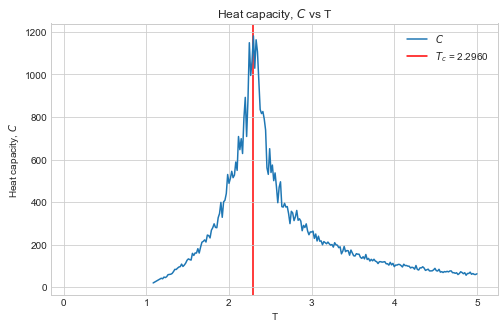

In [34]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp[60:],
                               Ts_loaded_temp[60:],
                               figsize = (8, 5),
                               lim_x   = (-0.15, 5.25) )

In [ ]:
Tc_25x25 = [2.2960, 2.2960]

# 30 x 30

In [46]:
Ts, spins_new = ising_model_2D( size_lattice   = (30, 30),
                                prob_spin_up   = 0.5,
                                period_burnout = 3500,
                                temp_range     = (0.1, 5),
                                n_temp_steps   = 300,
                                N              = 1000 )

100% |########################################################################|


In [47]:
# Saving variable to .pkl file >>
save_variables_to_file( [spins_new, Ts], "spins_new_Ts_30x30.pkl" )

### Run 1: 30 x 30 lattice

In [24]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/30x30/20210917_114014_spins_new_Ts_30x30.pkl")

100% |########################################################################|


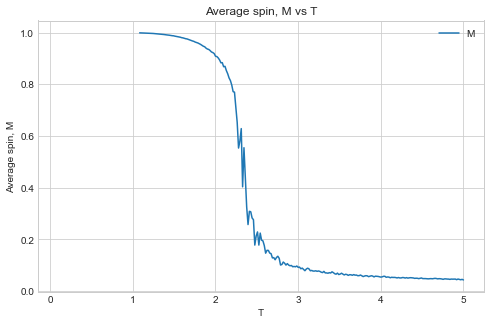

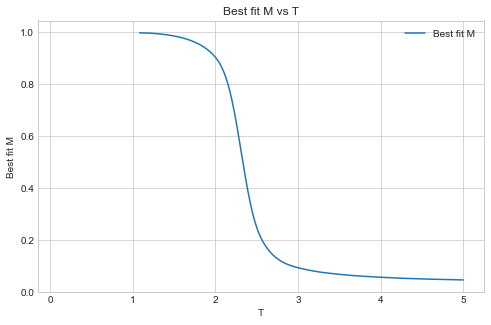

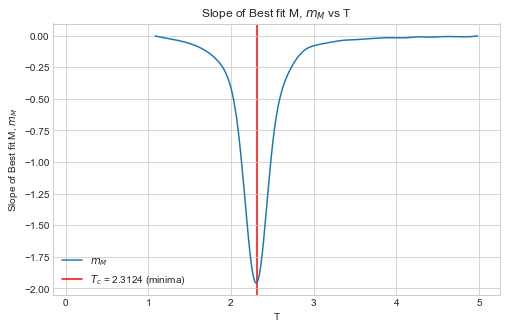

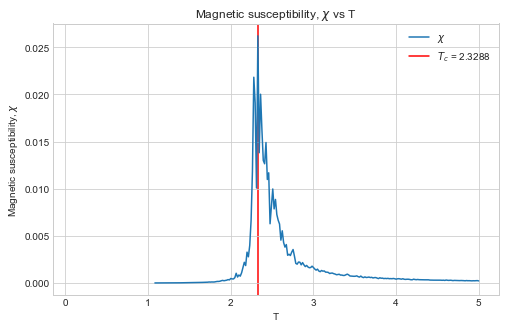

In [25]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp[60:],
                               Ts_loaded_temp[60:],
                               figsize = (8, 5),
                               lim_x   = (-0.15, 5.25) )

100% |########################################################################|


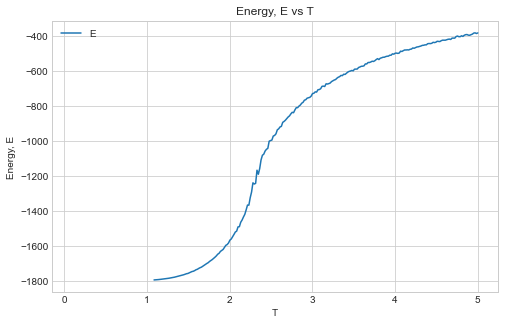

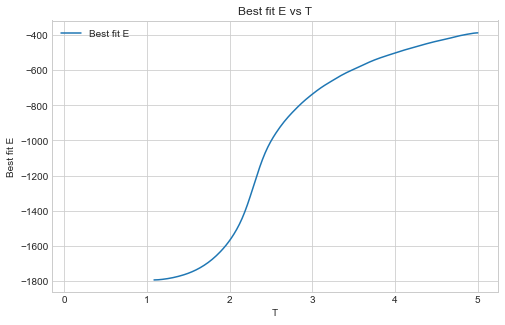

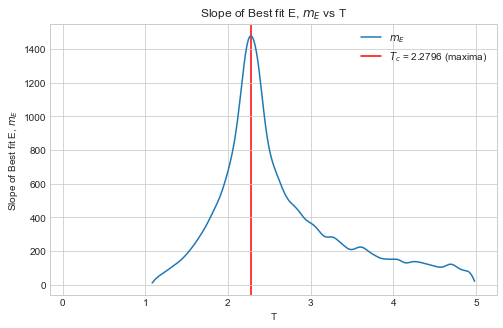

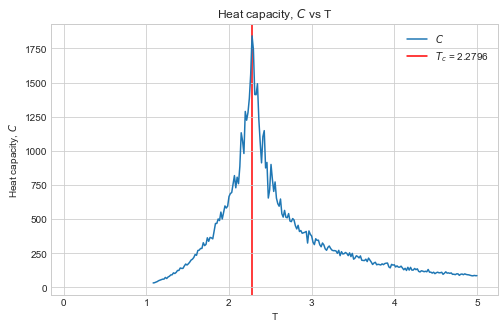

In [26]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp[60:],
                               Ts_loaded_temp[60:],
                               figsize = (8, 5),
                               lim_x   = (-0.15, 5.25) )

### Run 2: 30 x 30 lattice

In [21]:
# Loading variable from .pkl file >>
spins_new_loaded_temp, Ts_loaded_temp = load_variables_from_file("variables/30x30/20210918_075739_spins_new_Ts_30x30.pkl")

100% |########################################################################|


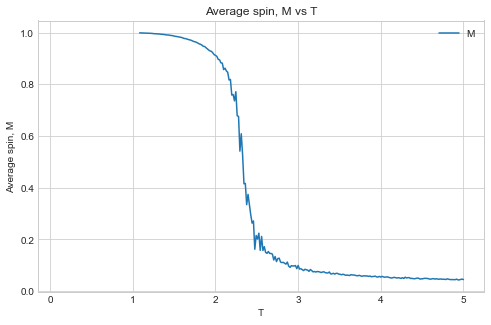

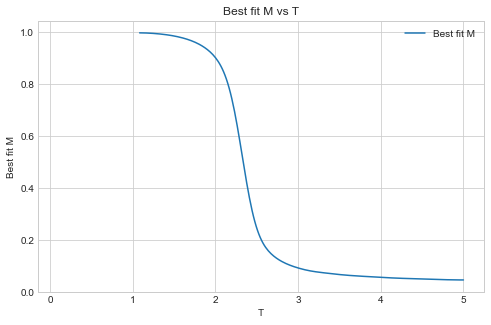

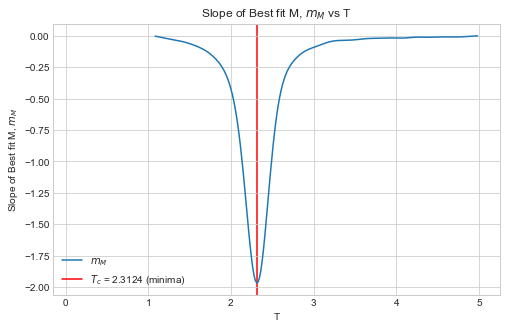

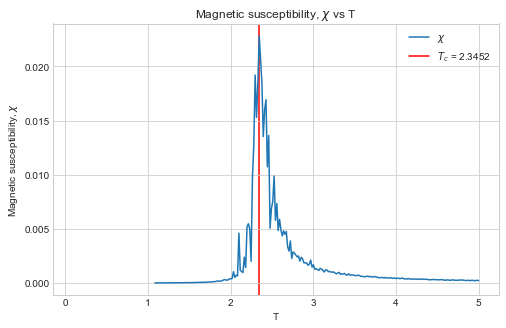

In [22]:
M_avg, X, figs = plot_M_and_X( spins_new_loaded_temp[60:],
                               Ts_loaded_temp[60:],
                               figsize = (8, 5),
                               lim_x   = (-0.15, 5.25) )

100% |########################################################################|


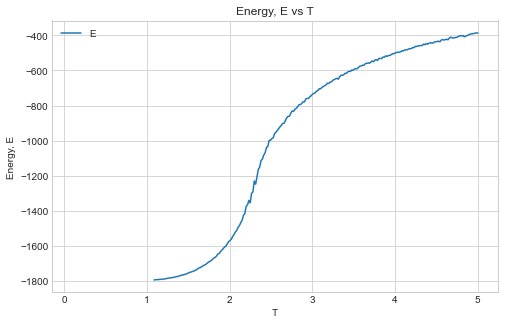

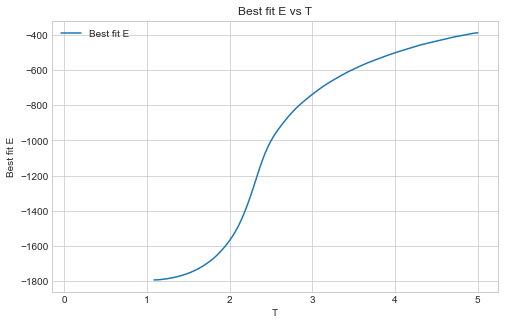

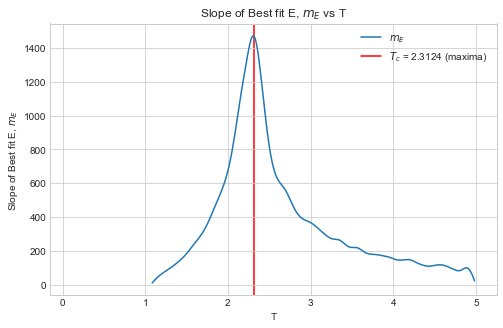

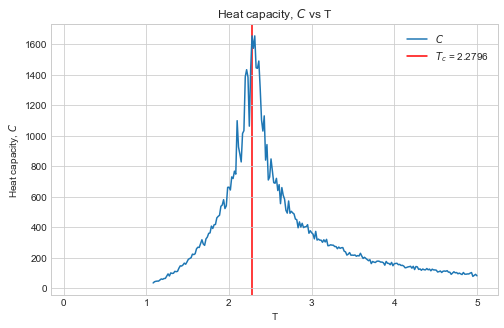

In [23]:
E_avg, C, figs = plot_E_and_C( spins_new_loaded_temp[60:],
                               Ts_loaded_temp[60:],
                               figsize = (8, 5),
                               lim_x   = (-0.15, 5.25) )

100% |########################################################################|


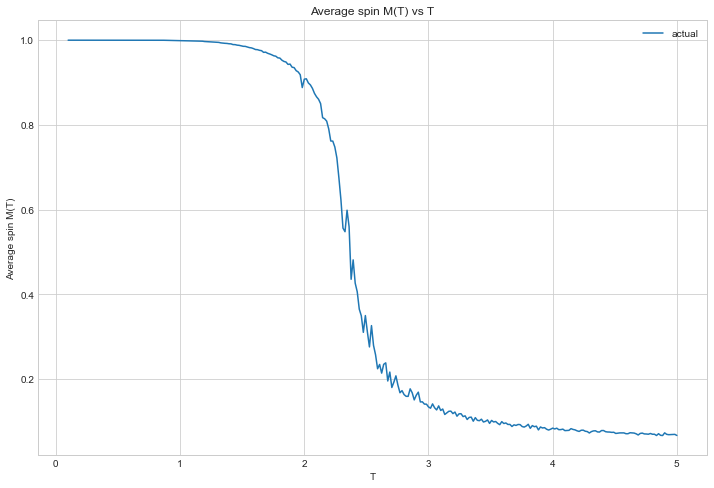

In [23]:
M_avg = plot_magnetisation( spins_new_loaded,
                            Ts_loaded,
                            figsize = (12, 8),
                            enable_best_fit = False )

100% |########################################################################|


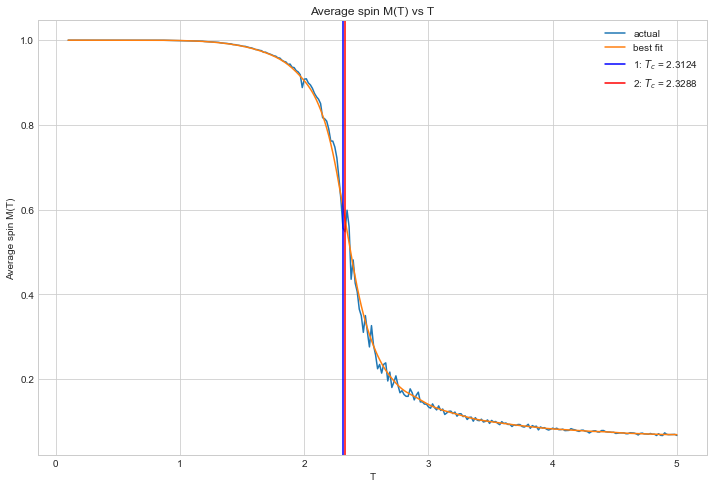

In [25]:
M_avg = plot_magnetisation( spins_new_loaded,
                            Ts_loaded,
                            figsize = (12, 8) )

100% |########################################################################|


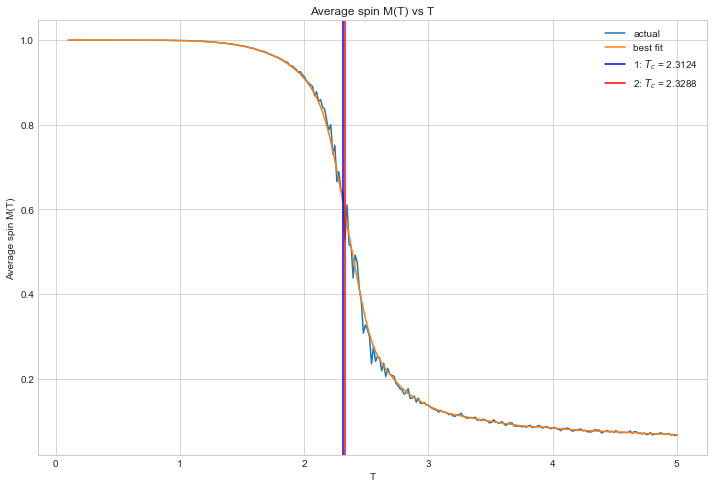

In [23]:
M_avg = plot_magnetisation( spins_new_loaded,
                            Ts_loaded,
                            figsize = (12, 8) )

100% |########################################################################|
No handles with labels found to put in legend.


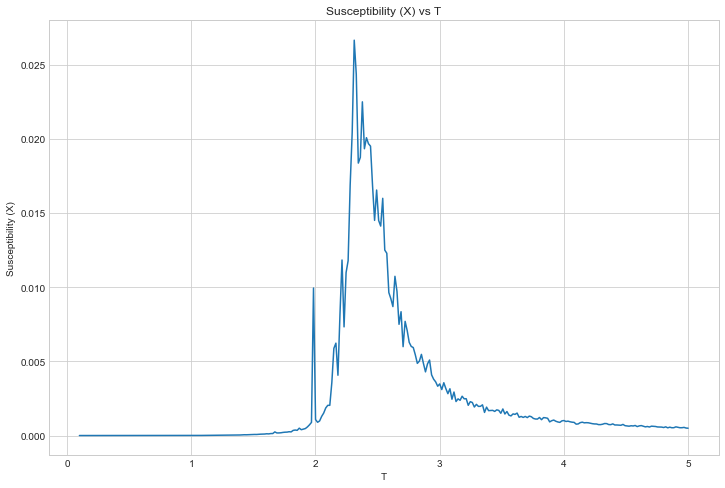

In [39]:
X = plot_susceptibility( spins_new_loaded,
                         Ts_loaded,
                         figsize = (12, 8),
                         enable_best_fit = False )

100% |########################################################################|
No handles with labels found to put in legend.


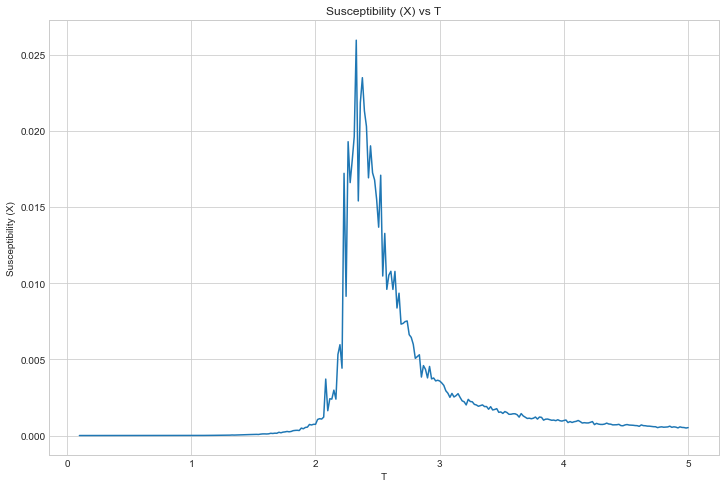

In [24]:
X = plot_susceptibility( spins_new_loaded,
                         Ts_loaded,
                         figsize = (12, 8),
                         enable_best_fit = False )

100% |########################################################################|


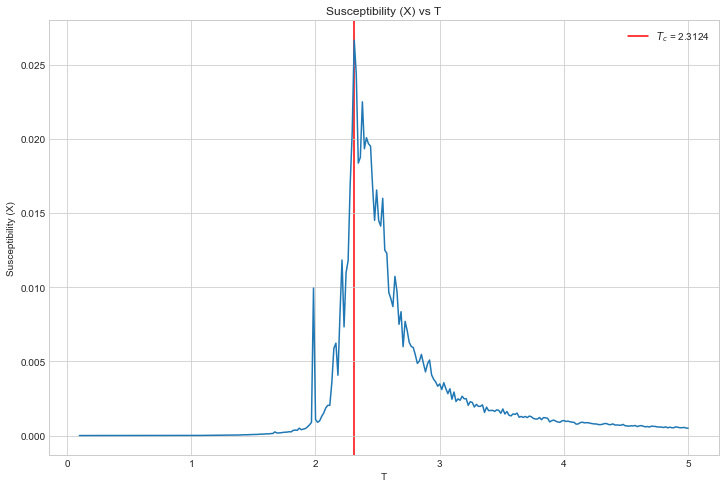

In [40]:
X = plot_susceptibility( spins_new_loaded,
                         Ts_loaded,
                         figsize = (12, 8) )

100% |########################################################################|


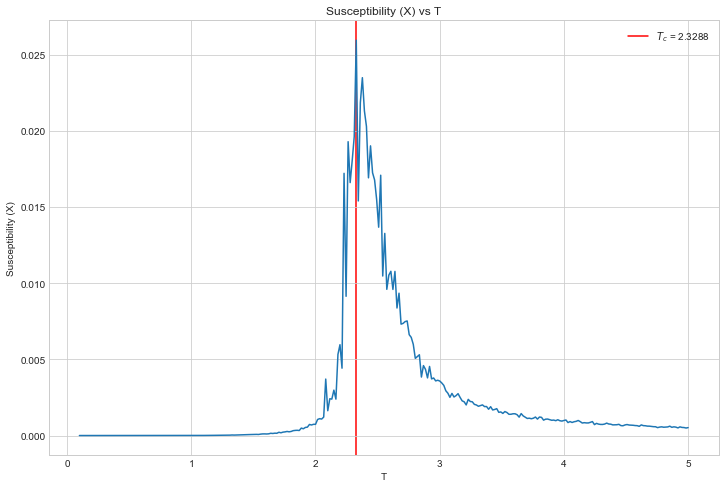

In [25]:
X = plot_susceptibility( spins_new_loaded,
                         Ts_loaded,
                         figsize = (12, 8) )

100% |########################################################################|


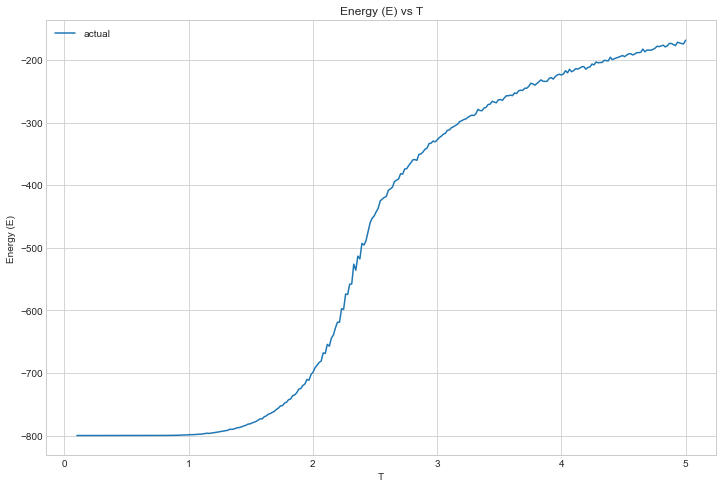

In [26]:
E_avg = plot_energy( spins_new_loaded,
                     Ts_loaded,
                     figsize = (12, 8),
                     enable_best_fit = False )

100% |########################################################################|


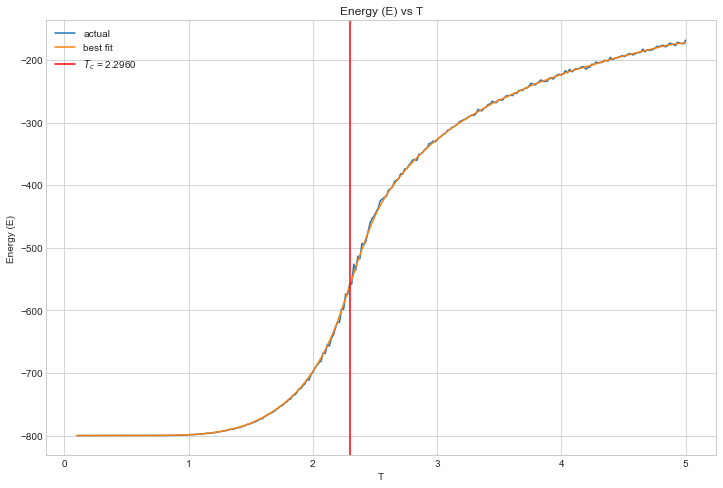

In [27]:
E_avg = plot_energy( spins_new_loaded,
                     Ts_loaded,
                     figsize = (12, 8) )

100% |########################################################################|


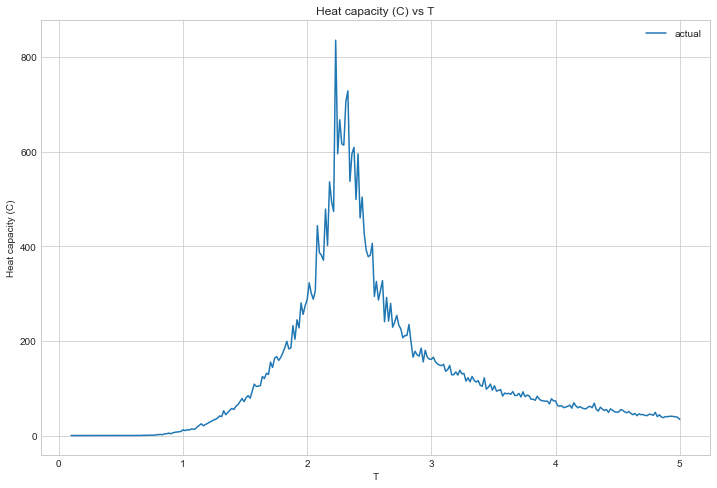

In [28]:
C = plot_heat_capacity( spins_new_loaded,
                        Ts_loaded,
                        figsize = (12, 8),
                        enable_best_fit = False )

100% |########################################################################|


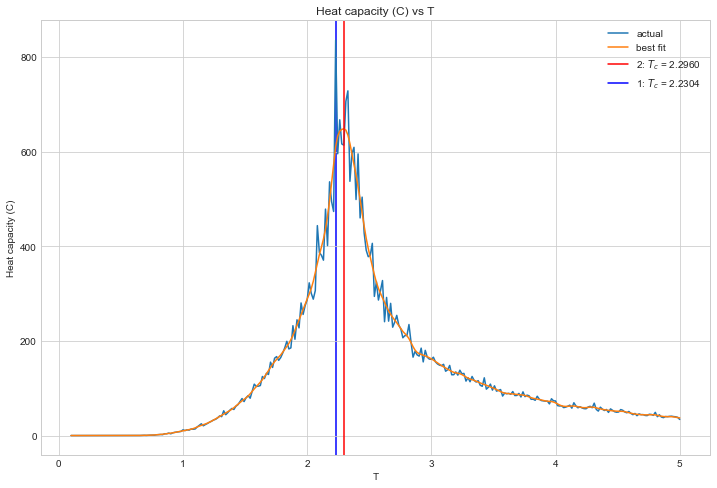

In [29]:
C = plot_heat_capacity( spins_new_loaded,
                        Ts_loaded,
                        figsize = (12, 8) )

# Curie temperature

In [ ]:
print(f"Tc(5 x 5) : {Tc_5x5})")
print(f"Tc(10x10) : {Tc_10x10})")
print(f"Tc(15x15) : {Tc_15x15})")
print(f"Tc(20x20) : {Tc_20x20})")
print(f"Tc(25x25) : {Tc_25x25})")

In [2]:
x = [15, 21, 22, 24, 28]
y = [17, 23, 27, 22, 30]

In [32]:
def cov(x, y):
    
    x = np.array( x )
    y = np.array( y )
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    print("mean_x:", mean_x)
    print("mean_y:", mean_y)
    
    delta_x = x - mean_x
    delta_y = y - mean_y
    
    print("delta_x:", delta_x)
    print("delta_y:", delta_y)
    
    val_cov = np.dot(delta_x, delta_y) / (len(x)-1)
    
    return val_cov

In [33]:
cov(x, y)

mean_x: 0.0
mean_y: -7.105427357601002e-16
delta_x: [-7. -1.  0.  2.  6.]
delta_y: [-6.8 -0.8  3.2 -1.8  6.2]


20.5

In [28]:
np.dot(x, y) / 4

20.5